z5516759 Tianyu Zhang

Part 1: Music Lyrics Classification

In [1]:
# Import required libraries
import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
import warnings
warnings.filterwarnings('ignore')
# Machine learning imports
from sklearn.naive_bayes import MultinomialNB, BernoulliNB
from sklearn.svm import SVC
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import (cross_val_score, StratifiedKFold, 
                                   cross_validate, GridSearchCV, train_test_split)
from sklearn.metrics import (classification_report, f1_score, precision_score, 
                           recall_score, confusion_matrix, accuracy_score)
from sklearn.preprocessing import LabelEncoder
from scipy import stats
# NLTK imports for text processing
import nltk
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer, WordNetLemmatizer
# Download NLTK data if not already present
try:
    nltk.data.find('corpora/stopwords')
    nltk.data.find('corpora/wordnet')
    nltk.data.find('tokenizers/punkt')
except LookupError:
    nltk.download('stopwords')
    nltk.download('wordnet')
    nltk.download('punkt')
    nltk.download('omw-1.4')
# Set plotting style
plt.style.use('default')
sns.set_palette("husl")
print("Libraries loaded")


Libraries loaded


[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\zhang\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\zhang\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\zhang\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\zhang\AppData\Roaming\nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


In [2]:
# Load and explore the dataset
def load_data():
    """Load the dataset from TSV file"""
    try:
        df = pd.read_csv('dataset.tsv', sep='\t', encoding='utf-8')
        print("Data loaded")
        print(f"Data shape: {df.shape}")
        return df
    except Exception as e:
        print(f"Error: {e}")
        return None
# Load data and perform basic analysis
df = load_data()
print(f"\nDataset size: {df.shape}")
print(f"Columns: {list(df.columns)}")
print(f"\nData types:\n{df.dtypes}")
print(f"\nMissing values:\n{df.isnull().sum()}")
# Display basic statistics
print("\nFirst 5 rows:")
print(df.head())
# Remove any rows with missing data (data cleaning)
df_clean = df.dropna().copy()
print(f"\nCleaned dataset size: {df_clean.shape}")


Data loaded
Data shape: (1500, 6)

Dataset size: (1500, 6)
Columns: ['artist_name', 'track_name', 'release_date', 'genre', 'lyrics', 'topic']

Data types:
artist_name     object
track_name      object
release_date     int64
genre           object
lyrics          object
topic           object
dtype: object

Missing values:
artist_name     0
track_name      0
release_date    0
genre           0
lyrics          0
topic           0
dtype: int64

First 5 rows:
                            artist_name         track_name  release_date  \
0                                loving  the not real lake          2016   
1                               incubus    into the summer          2019   
2                             reignwolf           hardcore          2016   
3                  tedeschi trucks band             anyhow          2016   
4  lukas nelson and promise of the real  if i started over          2017   

   genre                                             lyrics      topic  
0   rock  

Data distribution:
Topic distribution:
topic
dark         490
sadness      376
personal     347
lifestyle    205
emotion       82
Name: count, dtype: int64

Topic percentages:
topic
dark         32.67
sadness      25.07
personal     23.13
lifestyle    13.67
emotion       5.47
Name: count, dtype: float64

Imbalance ratio: 5.98


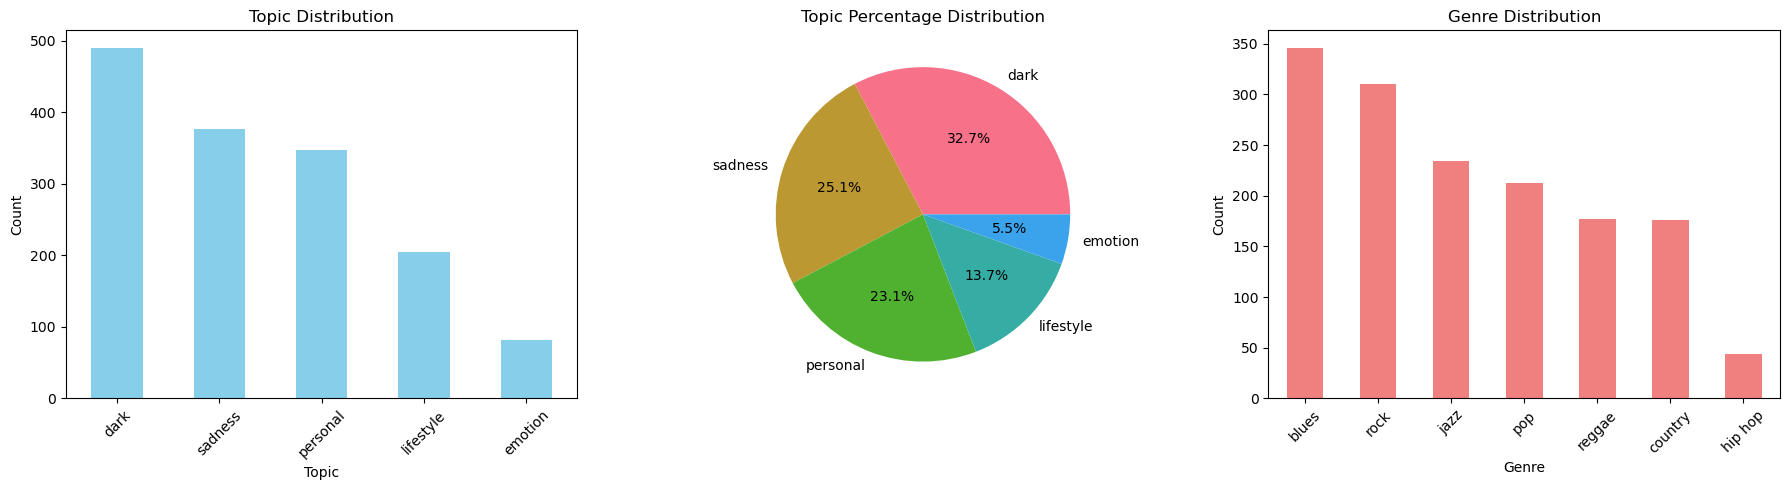


Dataset Assessment: Moderately Imbalanced
Imbalance ratio: 5.98 (max_class/min_class)


In [3]:
# Check data balance
print("Data distribution:")
# Analyze topic distribution
topic_distribution = df_clean['topic'].value_counts()
print("Topic distribution:")
print(topic_distribution)
print(f"\nTopic percentages:")
print((topic_distribution / len(df_clean) * 100).round(2))
# Calculate imbalance ratio
max_class = topic_distribution.max()
min_class = topic_distribution.min()
imbalance_ratio = max_class / min_class
print(f"\nImbalance ratio: {imbalance_ratio:.2f}")
# Visualize class distribution
fig, axes = plt.subplots(1, 3, figsize=(18, 5))
# Bar plot
topic_distribution.plot(kind='bar', ax=axes[0], color='skyblue')
axes[0].set_title('Topic Distribution')
axes[0].set_xlabel('Topic')
axes[0].set_ylabel('Count')
axes[0].tick_params(axis='x', rotation=45)
# Pie chart
axes[1].pie(topic_distribution.values, labels=topic_distribution.index, autopct='%1.1f%%')
axes[1].set_title('Topic Percentage Distribution')
# Genre distribution
genre_distribution = df_clean['genre'].value_counts()
genre_distribution.plot(kind='bar', ax=axes[2], color='lightcoral')
axes[2].set_title('Genre Distribution')
axes[2].set_xlabel('Genre')
axes[2].set_ylabel('Count')
axes[2].tick_params(axis='x', rotation=45)
plt.tight_layout()
plt.show()
# Determine dataset balance category
if imbalance_ratio <= 2:
    dataset_balance = "Balanced"
elif imbalance_ratio <= 5:
    dataset_balance = "Slightly Imbalanced"
elif imbalance_ratio <= 10:
    dataset_balance = "Moderately Imbalanced"
else:
    dataset_balance = "Heavily Imbalanced"
print(f"\nDataset Assessment: {dataset_balance}")
print(f"Imbalance ratio: {imbalance_ratio:.2f} (max_class/min_class)")


In [4]:
# Text preprocessing
def improved_clean_lyrics(text, preserve_contractions=True, remove_numbers=False):
    """Improved lyrics cleaning function with better punctuation handling"""
    if pd.isna(text):
        return ""
    text = str(text).lower()
    if preserve_contractions:
        # Preserve apostrophes for contractions
        text = re.sub(r"[^\w\s']", ' ', text)
        # Remove isolated apostrophes
        text = re.sub(r"\s'\s|\s'$|^'\s", ' ', text)
    else:
        # Remove all punctuation
        text = re.sub(r'[^\w\s]', ' ', text)
    if remove_numbers:
        # Remove numbers
        text = re.sub(r'\d+', '', text)
    # Remove extra whitespace
    text = re.sub(r'\s+', ' ', text)
    # Remove short words (less than 2 characters)
    words = text.split()
    words = [word for word in words if len(word) >= 2]
    return ' '.join(words)
def apply_stemming(text):
    """Apply stemming to text"""
    stemmer = PorterStemmer()
    words = text.split()
    return ' '.join([stemmer.stem(word) for word in words])
def apply_lemmatization(text):
    """Apply lemmatization to text"""
    lemmatizer = WordNetLemmatizer()
    words = text.split()
    return ' '.join([lemmatizer.lemmatize(word) for word in words])
# Define preprocessing configurations to test
preprocessing_configs = [
    {
        'name': 'Basic',
        'preserve_contractions': False,
        'remove_numbers': False,
        'stop_words': None,
        'word_processing': None
    },
    {
        'name': 'Preserve_Contractions',
        'preserve_contractions': True,
        'remove_numbers': False,
        'stop_words': None,
        'word_processing': None
    },
    {
        'name': 'Remove_Numbers',
        'preserve_contractions': True,
        'remove_numbers': True,
        'stop_words': None,
        'word_processing': None
    },
    {
        'name': 'NLTK_Stopwords',
        'preserve_contractions': True,
        'remove_numbers': True,
        'stop_words': 'nltk',
        'word_processing': None
    },
    {
        'name': 'Sklearn_Stopwords',
        'preserve_contractions': True,
        'remove_numbers': True,
        'stop_words': 'sklearn',
        'word_processing': None
    },
    {
        'name': 'With_Stemming',
        'preserve_contractions': True,
        'remove_numbers': True,
        'stop_words': 'sklearn',
        'word_processing': 'stem'
    },
    {
        'name': 'With_Lemmatization',
        'preserve_contractions': True,
        'remove_numbers': True,
        'stop_words': 'sklearn',
        'word_processing': 'lemma'
    }
]
def preprocess_text(text, config):
    """Apply preprocessing according to configuration"""
    # Basic cleaning
    cleaned = improved_clean_lyrics(
        text, 
        preserve_contractions=config['preserve_contractions'],
        remove_numbers=config['remove_numbers']
    )
    # Word processing
    if config['word_processing'] == 'stem':
        cleaned = apply_stemming(cleaned)
    elif config['word_processing'] == 'lemma':
        cleaned = apply_lemmatization(cleaned)
    return cleaned


In [5]:
# Testing different preprocessing methods
def evaluate_preprocessing(X, y, config):
    """Test how well this preprocessing works"""
    # Apply preprocessing
    X_processed = [preprocess_text(text, config) for text in X]
    # Get stopwords list
    if config['stop_words'] == 'nltk':
        stop_words_list = list(stopwords.words('english'))
    elif config['stop_words'] == 'sklearn':
        stop_words_list = 'english'
    else:
        stop_words_list = None
    # Create vectorizer
    vectorizer = CountVectorizer(stop_words=stop_words_list, max_features=5000)
    X_vectorized = vectorizer.fit_transform(X_processed)
    # Create models
    bnb = BernoulliNB()
    mnb = MultinomialNB()
    # Use cross-validation evaluation (fixes Problem 1 single split issue)
    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    bnb_scores = cross_val_score(bnb, X_vectorized, y, cv=cv, scoring='accuracy')
    mnb_scores = cross_val_score(mnb, X_vectorized, y, cv=cv, scoring='accuracy')
    return {
        'config_name': config['name'],
        'bnb_mean': bnb_scores.mean(),
        'bnb_std': bnb_scores.std(),
        'mnb_mean': mnb_scores.mean(),
        'mnb_std': mnb_scores.std(),
        'avg_performance': (bnb_scores.mean() + mnb_scores.mean()) / 2
    }
# Run preprocessing experiment
print("Testing preprocessing methods...")
preprocessing_results = []
for config in preprocessing_configs:
    print(f"Testing configuration: {config['name']}")
    result = evaluate_preprocessing(df_clean['lyrics'], df_clean['topic'], config)
    preprocessing_results.append(result)
    print(f"BNB: {result['bnb_mean']:.4f}±{result['bnb_std']:.4f}, "
          f"MNB: {result['mnb_mean']:.4f}±{result['mnb_std']:.4f}")
# Convert to DataFrame for analysis
results_df = pd.DataFrame(preprocessing_results)
print(f"\nPreprocessing experiment results summary:")
print(results_df.round(4))
# Find best configuration
best_config_name = results_df.loc[results_df['avg_performance'].idxmax(), 'config_name']
best_config = next(config for config in preprocessing_configs if config['name'] == best_config_name)
print(f"\n Best preprocessing configuration: {best_config_name}")
print(f"Best score: {results_df['avg_performance'].max():.4f}")
print("Configuration details:")
for key, value in best_config.items():
    if key != 'name':
        print(f"  {key}: {value}")


Testing preprocessing methods...
Testing configuration: Basic
BNB: 0.5660±0.0158, MNB: 0.8107±0.0268
Testing configuration: Preserve_Contractions
BNB: 0.5660±0.0158, MNB: 0.8107±0.0268
Testing configuration: Remove_Numbers
BNB: 0.5660±0.0158, MNB: 0.8107±0.0268
Testing configuration: NLTK_Stopwords
BNB: 0.5667±0.0169, MNB: 0.8100±0.0302
Testing configuration: Sklearn_Stopwords
BNB: 0.5627±0.0232, MNB: 0.8027±0.0246
Testing configuration: With_Stemming
BNB: 0.5553±0.0209, MNB: 0.7947±0.0244
Testing configuration: With_Lemmatization
BNB: 0.5620±0.0177, MNB: 0.7933±0.0273

Preprocessing experiment results summary:
             config_name  bnb_mean  bnb_std  mnb_mean  mnb_std  \
0                  Basic    0.5660   0.0158    0.8107   0.0268   
1  Preserve_Contractions    0.5660   0.0158    0.8107   0.0268   
2         Remove_Numbers    0.5660   0.0158    0.8107   0.0268   
3         NLTK_Stopwords    0.5667   0.0169    0.8100   0.0302   
4      Sklearn_Stopwords    0.5627   0.0232    0.80

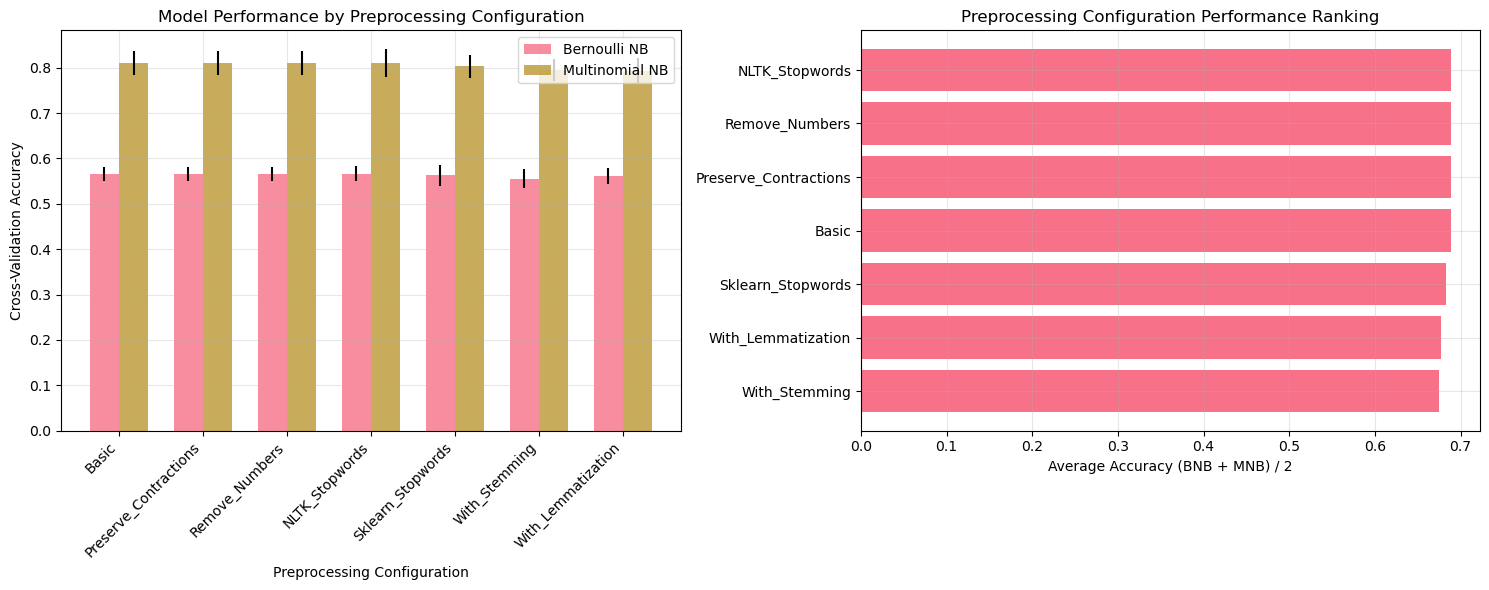

In [6]:
# Visualize preprocessing results
fig, axes = plt.subplots(1, 2, figsize=(15, 6))
# Bar chart comparison
x_pos = np.arange(len(results_df))
width = 0.35
axes[0].bar(x_pos - width/2, results_df['bnb_mean'], width, 
           label='Bernoulli NB', alpha=0.8, yerr=results_df['bnb_std'])
axes[0].bar(x_pos + width/2, results_df['mnb_mean'], width, 
           label='Multinomial NB', alpha=0.8, yerr=results_df['mnb_std'])
axes[0].set_xlabel('Preprocessing Configuration')
axes[0].set_ylabel('Cross-Validation Accuracy')
axes[0].set_title('Model Performance by Preprocessing Configuration')
axes[0].set_xticks(x_pos)
axes[0].set_xticklabels(results_df['config_name'], rotation=45, ha='right')
axes[0].legend()
axes[0].grid(True, alpha=0.3)
# Average performance ranking
sorted_results = results_df.sort_values('avg_performance', ascending=True)
axes[1].barh(range(len(sorted_results)), sorted_results['avg_performance'])
axes[1].set_yticks(range(len(sorted_results)))
axes[1].set_yticklabels(sorted_results['config_name'])
axes[1].set_xlabel('Average Accuracy (BNB + MNB) / 2')
axes[1].set_title('Preprocessing Configuration Performance Ranking')
axes[1].grid(True, alpha=0.3)
plt.tight_layout()
plt.show()


In [7]:
# Comparing BNB vs MNB models
# Prepare data using best preprocessing configuration
X_processed = [preprocess_text(text, best_config) for text in df_clean['lyrics']]
y = df_clean['topic']
# Get stopwords based on best config
if best_config['stop_words'] == 'nltk':
    stop_words_list = list(stopwords.words('english'))
elif best_config['stop_words'] == 'sklearn':
    stop_words_list = 'english'
else:
    stop_words_list = None
# Vectorize using best configuration
vectorizer = CountVectorizer(stop_words=stop_words_list, max_features=5000)
X_vectorized = vectorizer.fit_transform(X_processed)
print(f"Feature count: {X_vectorized.shape[1]}")
print(f"Sample count: {X_vectorized.shape[0]}")
# Define evaluation metrics
scoring_metrics = {
    'accuracy': 'accuracy',
    'precision_macro': 'precision_macro',
    'recall_macro': 'recall_macro',
    'f1_macro': 'f1_macro',
    'precision_weighted': 'precision_weighted',
    'recall_weighted': 'recall_weighted',
    'f1_weighted': 'f1_weighted'
}
# Create models
models = {
    'Bernoulli_NB': BernoulliNB(),
    'Multinomial_NB': MultinomialNB()
}
# Perform detailed cross-validation evaluation
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
detailed_results = {}
print("\nDetailed Model Evaluation:")
for model_name, model in models.items():
    print(f"Evaluating {model_name}...")
    # Cross-validation evaluation
    cv_results = cross_validate(
        model, X_vectorized, y, 
        cv=cv, 
        scoring=scoring_metrics,
        return_train_score=False
    )
    # Calculate statistics
    model_results = {}
    for metric, scores in cv_results.items():
        if metric.startswith('test_'):
            metric_name = metric.replace('test_', '')
            model_results[metric_name] = {
                'mean': scores.mean(),
                'std': scores.std(),
                'scores': scores
            }
    detailed_results[model_name] = model_results
# Display detailed results
main_metrics = ['accuracy', 'f1_macro', 'f1_weighted']
for metric in main_metrics:
    print(f"\n{metric.upper()}:")
    for model_name in ['Bernoulli_NB', 'Multinomial_NB']:
        mean_val = detailed_results[model_name][metric]['mean']
        std_val = detailed_results[model_name][metric]['std']
        print(f"  {model_name:>15}: {mean_val:.4f} ± {std_val:.4f}")


Feature count: 5000
Sample count: 1500

Detailed Model Evaluation:
Evaluating Bernoulli_NB...
Evaluating Multinomial_NB...

ACCURACY:
     Bernoulli_NB: 0.5660 ± 0.0158
   Multinomial_NB: 0.8107 ± 0.0268

F1_MACRO:
     Bernoulli_NB: 0.4082 ± 0.0133
   Multinomial_NB: 0.7713 ± 0.0331

F1_WEIGHTED:
     Bernoulli_NB: 0.5282 ± 0.0132
   Multinomial_NB: 0.8099 ± 0.0267


BNB vs MNB comparison:

ACCURACY:
  BNB: 0.5660 ± 0.0158
  MNB: 0.8107 ± 0.0268
  Difference: 0.2447
  t-statistic: -15.9190
  p-value: 0.0001
  Result: MNB significantly better (p<0.05)

F1_MACRO:
  BNB: 0.4082 ± 0.0133
  MNB: 0.7713 ± 0.0331
  Difference: 0.3631
  t-statistic: -17.7828
  p-value: 0.0001
  Result: MNB significantly better (p<0.05)

F1_WEIGHTED:
  BNB: 0.5282 ± 0.0132
  MNB: 0.8099 ± 0.0267
  Difference: 0.2817
  t-statistic: -16.5802
  p-value: 0.0001
  Result: MNB significantly better (p<0.05)


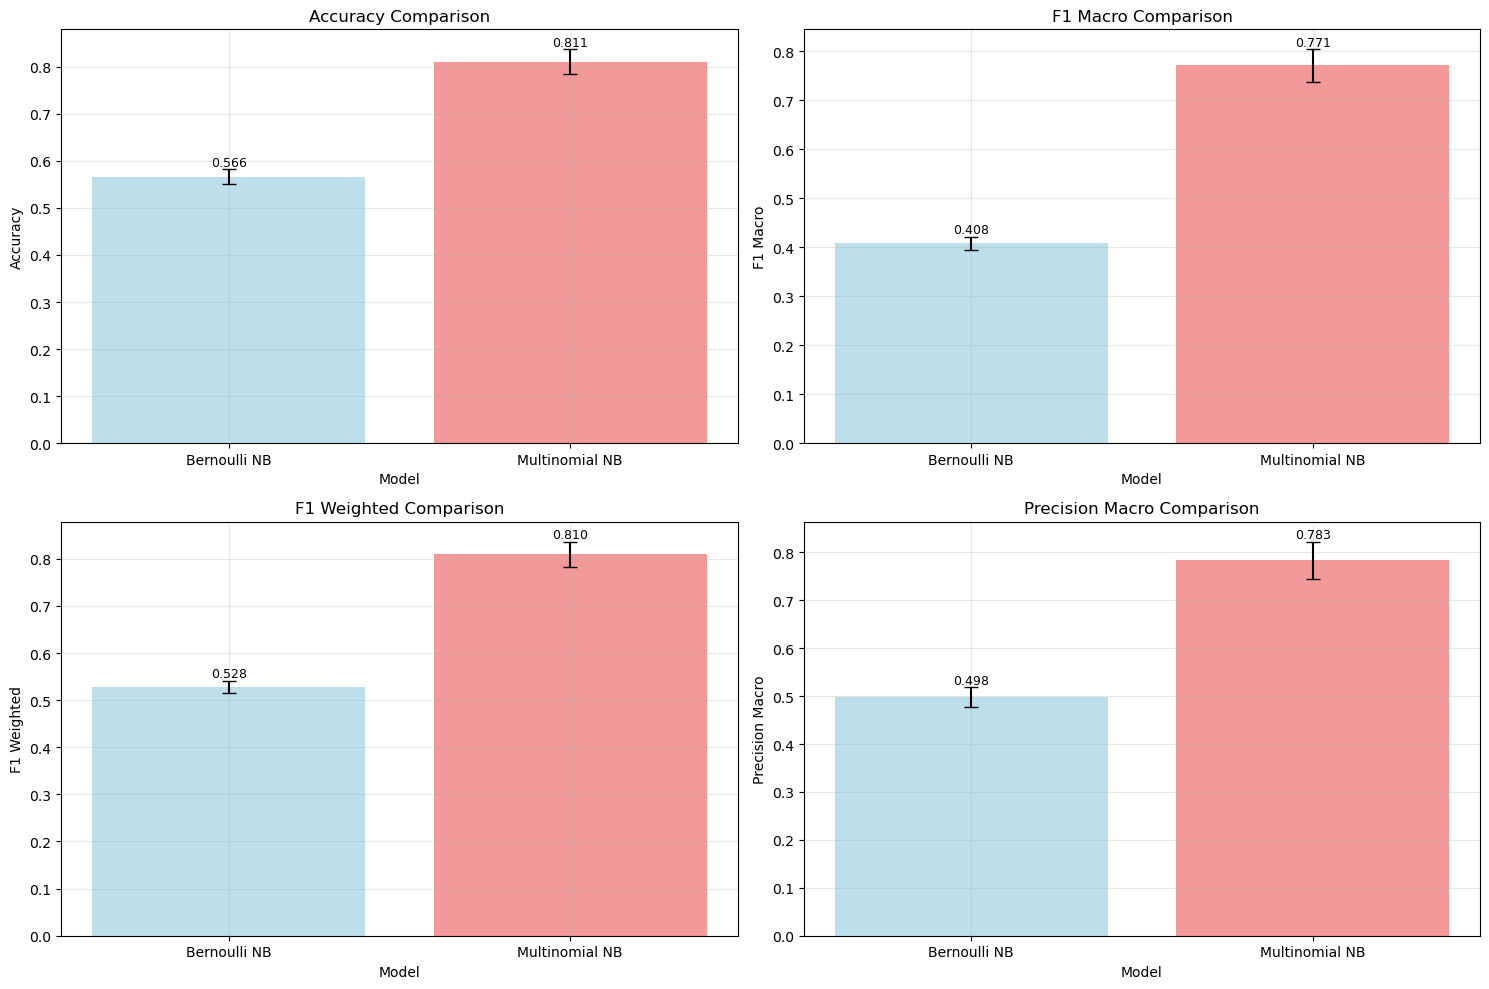


Problem 3 Final Conclusion:
Winner: Multinomial Naive Bayes (MNB)
MNB better by: 28.17%
Recommended for subsequent experiments: Multinomial Naive Bayes (MNB)


In [8]:
# Statistical Significance Analysis and Model Comparison Visualization
# Perform paired t-tests for statistical significance
print("BNB vs MNB comparison:")
for metric in ['accuracy', 'f1_macro', 'f1_weighted']:
    bnb_scores = detailed_results['Bernoulli_NB'][metric]['scores']
    mnb_scores = detailed_results['Multinomial_NB'][metric]['scores']
    # Paired t-test
    t_stat, p_value = stats.ttest_rel(bnb_scores, mnb_scores)
    print(f"\n{metric.upper()}:")
    print(f"  BNB: {bnb_scores.mean():.4f} ± {bnb_scores.std():.4f}")
    print(f"  MNB: {mnb_scores.mean():.4f} ± {mnb_scores.std():.4f}")
    print(f"  Difference: {(mnb_scores.mean() - bnb_scores.mean()):.4f}")
    print(f"  t-statistic: {t_stat:.4f}")
    print(f"  p-value: {p_value:.4f}")
    if p_value < 0.05:
        better_model = "MNB" if mnb_scores.mean() > bnb_scores.mean() else "BNB"
        print(f"  Result: {better_model} significantly better (p<0.05)")
    else:
        print(f"  Result: No significant difference (p≥0.05)")
# Visualization of comparison results
fig, axes = plt.subplots(2, 2, figsize=(15, 10))
metrics_to_plot = ['accuracy', 'f1_macro', 'f1_weighted', 'precision_macro']
model_names = list(detailed_results.keys())
for idx, metric in enumerate(metrics_to_plot):
    ax = axes[idx // 2, idx % 2]
    means = [detailed_results[model][metric]['mean'] for model in model_names]
    stds = [detailed_results[model][metric]['std'] for model in model_names]
    x_pos = np.arange(len(model_names))
    bars = ax.bar(x_pos, means, yerr=stds, capsize=5, 
                  color=['lightblue', 'lightcoral'], alpha=0.8)
    ax.set_xlabel('Model')
    ax.set_ylabel(metric.replace('_', ' ').title())
    ax.set_title(f'{metric.replace("_", " ").title()} Comparison')
    ax.set_xticks(x_pos)
    ax.set_xticklabels([name.replace('_', ' ') for name in model_names])
    ax.grid(True, alpha=0.3)
    # Add value labels
    for bar, mean, std in zip(bars, means, stds):
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2., height + std + 0.001,
                f'{mean:.3f}', ha='center', va='bottom', fontsize=9)
plt.tight_layout()
plt.show()
# Final conclusion for Problem 3
bnb_f1_weighted = detailed_results['Bernoulli_NB']['f1_weighted']['mean']
mnb_f1_weighted = detailed_results['Multinomial_NB']['f1_weighted']['mean']
print(f"\n{'='*50}")
print("Problem 3 Final Conclusion:")
print(f"{'='*50}")
if mnb_f1_weighted > bnb_f1_weighted:
    winner = "Multinomial Naive Bayes (MNB)"
    advantage = (mnb_f1_weighted - bnb_f1_weighted) * 100
else:
    winner = "Bernoulli Naive Bayes (BNB)"
    advantage = (bnb_f1_weighted - mnb_f1_weighted) * 100
print(f"Winner: {winner}")
print(f"MNB better by: {advantage:.2f}%")
print(f"Recommended for subsequent experiments: {winner}")
# Store winning model for next problems
if mnb_f1_weighted > bnb_f1_weighted:
    nb_winner = "MNB"
    nb_winner_model = MultinomialNB()
else:
    nb_winner = "BNB"
    nb_winner_model = BernoulliNB()


In [9]:
# Testing different feature counts
def test_feature_counts(X_processed, y, feature_counts, config):
    """Evaluate different feature count settings"""
    results = {}
    # Get stopwords
    if config['stop_words'] == 'nltk':
        stop_words_list = list(stopwords.words('english'))
    elif config['stop_words'] == 'sklearn':
        stop_words_list = 'english'
    else:
        stop_words_list = None
    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    for n_features in feature_counts:
        print(f"Testing {n_features} features...")
        # Create vectorizer
        vectorizer = CountVectorizer(
            stop_words=stop_words_list, 
            max_features=n_features
        )
        X_vectorized = vectorizer.fit_transform(X_processed)
        # Evaluate models
        bnb = BernoulliNB()
        mnb = MultinomialNB()
        bnb_scores = cross_val_score(bnb, X_vectorized, y, cv=cv, scoring='f1_weighted')
        mnb_scores = cross_val_score(mnb, X_vectorized, y, cv=cv, scoring='f1_weighted')
        results[n_features] = {
            'BNB_mean': bnb_scores.mean(),
            'BNB_std': bnb_scores.std(),
            'MNB_mean': mnb_scores.mean(),
            'MNB_std': mnb_scores.std(),
            'actual_features': X_vectorized.shape[1]
        }
    return results
# Test different feature counts
feature_counts = [500, 1000, 2000, 3000, 5000, 7000, 10000, 15000, 20000, None]
print("Testing feature counts...")
feature_results = test_feature_counts(X_processed, y, feature_counts, best_config)
# Create results DataFrame
feature_df_data = []
for n_features, metrics in feature_results.items():
    feature_df_data.append({
        'max_features': n_features if n_features is not None else 'All',
        'actual_features': metrics['actual_features'],
        'BNB_mean': metrics['BNB_mean'],
        'BNB_std': metrics['BNB_std'],
        'MNB_mean': metrics['MNB_mean'],
        'MNB_std': metrics['MNB_std']
    })
feature_df = pd.DataFrame(feature_df_data)
print("\nFeature count experiment results:")
print(feature_df.round(4))
# Prepare data for visualization
feature_nums = [row['actual_features'] for row in feature_df_data]
bnb_means = [row['BNB_mean'] for row in feature_df_data]
bnb_stds = [row['BNB_std'] for row in feature_df_data]
mnb_means = [row['MNB_mean'] for row in feature_df_data]
mnb_stds = [row['MNB_std'] for row in feature_df_data]


Testing feature counts...
Testing 500 features...
Testing 1000 features...
Testing 2000 features...
Testing 3000 features...
Testing 5000 features...
Testing 7000 features...
Testing 10000 features...
Testing 15000 features...
Testing 20000 features...
Testing None features...

Feature count experiment results:
  max_features  actual_features  BNB_mean  BNB_std  MNB_mean  MNB_std
0          500              500    0.6661   0.0118    0.8784   0.0234
1         1000             1000    0.6386   0.0139    0.8372   0.0175
2         2000             2000    0.5999   0.0140    0.8252   0.0247
3         3000             3000    0.5764   0.0149    0.8186   0.0275
4         5000             5000    0.5282   0.0132    0.8099   0.0267
5         7000             7000    0.4983   0.0177    0.7948   0.0257
6        10000             8495    0.4730   0.0198    0.7902   0.0240
7        15000             8495    0.4730   0.0198    0.7902   0.0240
8        20000             8495    0.4730   0.0198    0.7

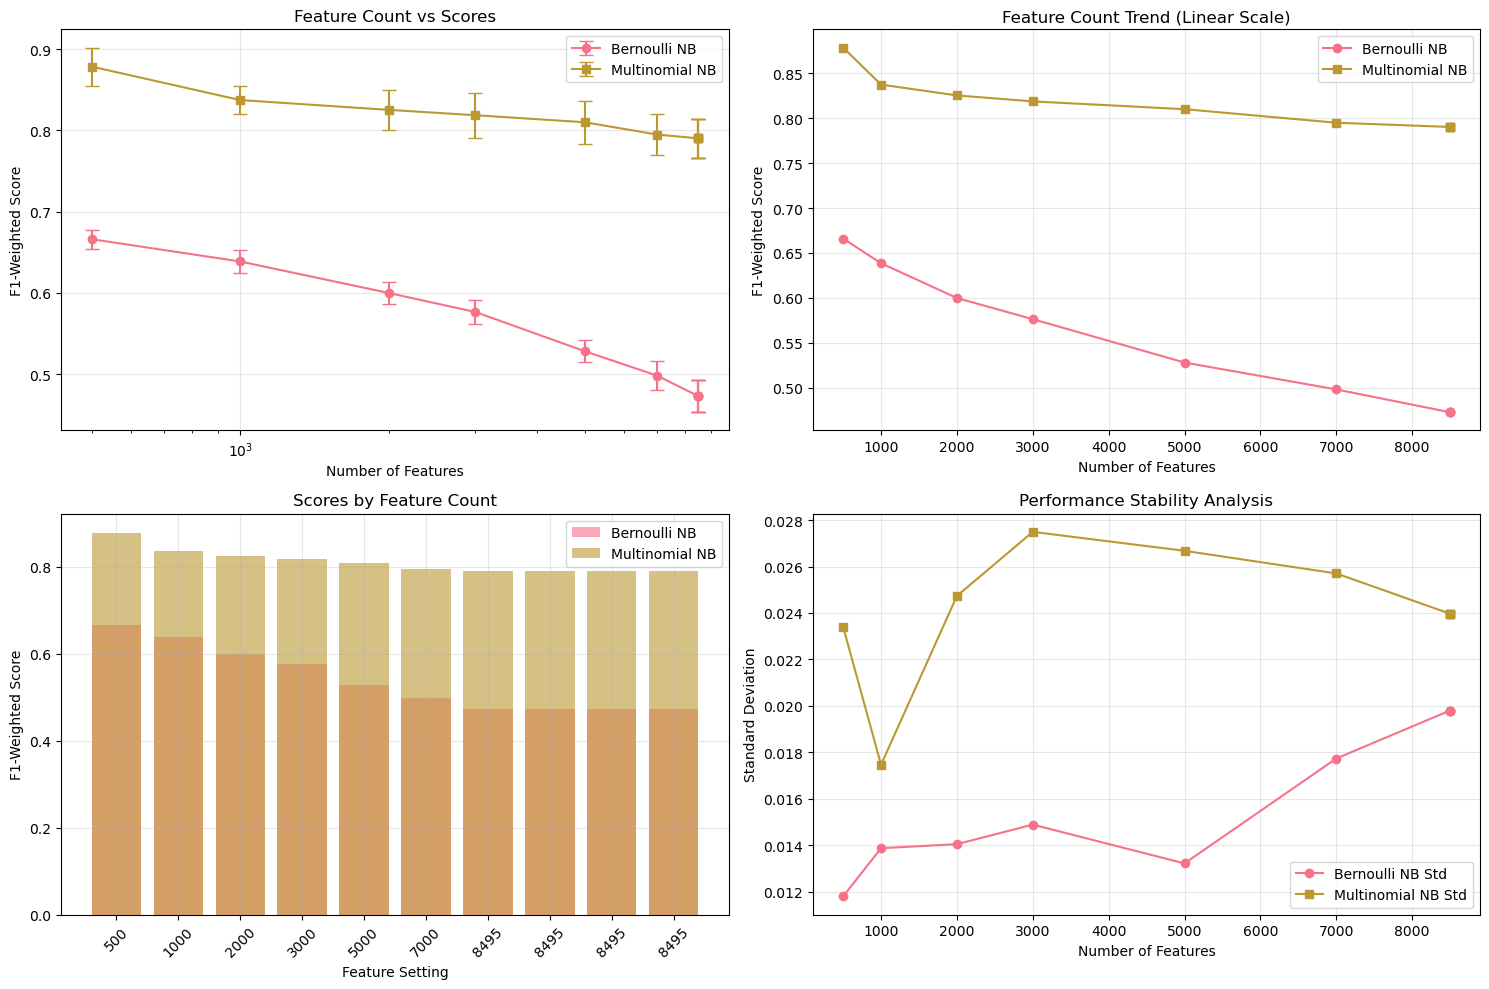


 Feature Count Analysis Results:

Bernoulli NB best feature count: 500
  Performance: 0.6661 ± 0.0118
Multinomial NB best feature count: 500
  Performance: 0.8784 ± 0.0234

 Best feature count: 500
   Good balance of performance and features
   Average performance: 0.7722


In [10]:
# Visualize feature count impact and find best setting
plt.figure(figsize=(15, 10))
plt.subplot(2, 2, 1)
plt.errorbar(feature_nums, bnb_means, yerr=bnb_stds, 
             marker='o', label='Bernoulli NB', capsize=5)
plt.errorbar(feature_nums, mnb_means, yerr=mnb_stds, 
             marker='s', label='Multinomial NB', capsize=5)
plt.xlabel('Number of Features')
plt.ylabel('F1-Weighted Score')
plt.title('Feature Count vs Scores')
plt.legend()
plt.grid(True, alpha=0.3)
plt.xscale('log')
plt.subplot(2, 2, 2)
plt.plot(feature_nums, bnb_means, 'o-', label='Bernoulli NB')
plt.plot(feature_nums, mnb_means, 's-', label='Multinomial NB')
plt.xlabel('Number of Features')
plt.ylabel('F1-Weighted Score')
plt.title('Feature Count Trend (Linear Scale)')
plt.legend()
plt.grid(True, alpha=0.3)
plt.subplot(2, 2, 3)
plt.bar(range(len(feature_nums)), bnb_means, alpha=0.6, label='Bernoulli NB')
plt.bar(range(len(feature_nums)), mnb_means, alpha=0.6, label='Multinomial NB')
plt.xlabel('Feature Setting')
plt.ylabel('F1-Weighted Score')
plt.title('Scores by Feature Count')
plt.xticks(range(len(feature_nums)), 
           [str(f) if f < 20000 else 'All' for f in feature_nums], rotation=45)
plt.legend()
plt.grid(True, alpha=0.3)
plt.subplot(2, 2, 4)
plt.plot(feature_nums, bnb_stds, 'o-', label='Bernoulli NB Std')
plt.plot(feature_nums, mnb_stds, 's-', label='Multinomial NB Std')
plt.xlabel('Number of Features')
plt.ylabel('Standard Deviation')
plt.title('Performance Stability Analysis')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()
# Find best feature count
best_bnb_idx = np.argmax(bnb_means)
best_mnb_idx = np.argmax(mnb_means)
print(f"\n Feature Count Analysis Results:")
print("")
print(f"Bernoulli NB best feature count: {feature_nums[best_bnb_idx]}")
print(f"  Performance: {bnb_means[best_bnb_idx]:.4f} ± {bnb_stds[best_bnb_idx]:.4f}")
print(f"Multinomial NB best feature count: {feature_nums[best_mnb_idx]}")
print(f"  Performance: {mnb_means[best_mnb_idx]:.4f} ± {mnb_stds[best_mnb_idx]:.4f}")
# Find efficient choice (99% of best performance with fewer features)
performance_threshold = 0.99
max_bnb_score = max(bnb_means)
max_mnb_score = max(mnb_means)
efficient_choices = []
for i, (features, bnb_score, mnb_score) in enumerate(zip(feature_nums, bnb_means, mnb_means)):
    if (bnb_score >= max_bnb_score * performance_threshold and 
        mnb_score >= max_mnb_score * performance_threshold):
        efficient_choices.append((features, (bnb_score + mnb_score) / 2))
if efficient_choices:
    best_features = min(efficient_choices, key=lambda x: x[0])
    print(f"\n Best feature count: {best_features[0]}")
    print(f"   Good balance of performance and features")
    print(f"   Average performance: {best_features[1]:.4f}")
else:
    combined_scores = [(f, (b+m)/2) for f, b, m in zip(feature_nums, bnb_means, mnb_means)]
    optimal = max(combined_scores, key=lambda x: x[1])
    print(f"\n Best feature count: {optimal[0]}")
    print(f"   Average performance: {optimal[1]:.4f}")
# Store best feature count for next problem
optimal_n_features = best_features[0] if efficient_choices else optimal[0]


In [11]:
# Adding SVM and comparing all models
# What I expect from SVM
print("What I expect from SVM:")
print("Based on what I know about SVM:")
print("1. SVM will outperform Naive Bayes methods on F1-weighted score")
print("2. SVM will handle class imbalance better (higher macro-F1)")
print("3. SVM will have better generalization (lower standard deviation)")
# Prepare data configuration
if best_config['stop_words'] == 'nltk':
    stop_words_list = list(stopwords.words('english'))
elif best_config['stop_words'] == 'sklearn':
    stop_words_list = 'english'
else:
    stop_words_list = None
# Use best feature count
vectorizer_best = CountVectorizer(
    stop_words=stop_words_list, 
    max_features=optimal_n_features
)
X_best = vectorizer_best.fit_transform(X_processed)
print(f"\nUsing {X_best.shape[1]} features for SVM training")
# Finding best SVM settings
svm_param_grid = {
    'C': [0.1, 1, 10, 100],
    'class_weight': [None, 'balanced']
}
# Grid search for best SVM parameters
svm_base = SVC(kernel='linear', random_state=42)
print("\nTesting SVM parameters...")
svm_grid_search = GridSearchCV(
    svm_base, 
    svm_param_grid, 
    cv=StratifiedKFold(n_splits=5, shuffle=True, random_state=42),
    scoring='f1_weighted',
    n_jobs=-1
)
svm_grid_search.fit(X_best, y)
print(f"Best SVM parameters: {svm_grid_search.best_params_}")
print(f"Best SVM cross-validation score: {svm_grid_search.best_score_:.4f}")
# Get best SVM model
best_svm = svm_grid_search.best_estimator_


What I expect from SVM:
Based on what I know about SVM:
1. SVM will outperform Naive Bayes methods on F1-weighted score
2. SVM will handle class imbalance better (higher macro-F1)
3. SVM will have better generalization (lower standard deviation)

Using 500 features for SVM training

Testing SVM parameters...
Best SVM parameters: {'C': 0.1, 'class_weight': None}
Best SVM cross-validation score: 0.8360


In [12]:
# Comparing all three models
# Ensure fair comparison with best settings
bnb_best = BernoulliNB()
mnb_best = MultinomialNB()
final_models = {
    'Bernoulli_NB': bnb_best,
    'Multinomial_NB': mnb_best,
    'SVM': best_svm
}
# Testing all models
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
final_results = {}
# Model results
for model_name, model in final_models.items():
    cv_results = cross_validate(
        model, X_best, y,
        cv=cv,
        scoring=scoring_metrics,
        return_train_score=False
    )
    model_metrics = {}
    for metric, scores in cv_results.items():
        if metric.startswith('test_'):
            metric_name = metric.replace('test_', '')
            model_metrics[metric_name] = {
                'mean': scores.mean(),
                'std': scores.std(),
                'scores': scores
            }
    final_results[model_name] = model_metrics
# Display results
# Final Model Performance Comparison
metrics_of_interest = ['accuracy', 'f1_macro', 'f1_weighted', 'precision_macro', 'recall_macro']
for metric in metrics_of_interest:
    print(f"\n{metric.upper().replace('_', ' ')}:")
    for model_name in final_models.keys():
        mean_val = final_results[model_name][metric]['mean']
        std_val = final_results[model_name][metric]['std']
        print(f"  {model_name:>15}: {mean_val:.4f} ± {std_val:.4f}")



ACCURACY:
     Bernoulli_NB: 0.6753 ± 0.0144
   Multinomial_NB: 0.8787 ± 0.0230
              SVM: 0.8367 ± 0.0224

F1 MACRO:
     Bernoulli_NB: 0.5748 ± 0.0111
   Multinomial_NB: 0.8586 ± 0.0278
              SVM: 0.8135 ± 0.0202

F1 WEIGHTED:
     Bernoulli_NB: 0.6661 ± 0.0118
   Multinomial_NB: 0.8784 ± 0.0234
              SVM: 0.8360 ± 0.0219

PRECISION MACRO:
     Bernoulli_NB: 0.5909 ± 0.0123
   Multinomial_NB: 0.8689 ± 0.0261
              SVM: 0.8305 ± 0.0267

RECALL MACRO:
     Bernoulli_NB: 0.5738 ± 0.0106
   Multinomial_NB: 0.8513 ± 0.0306
              SVM: 0.8028 ± 0.0225


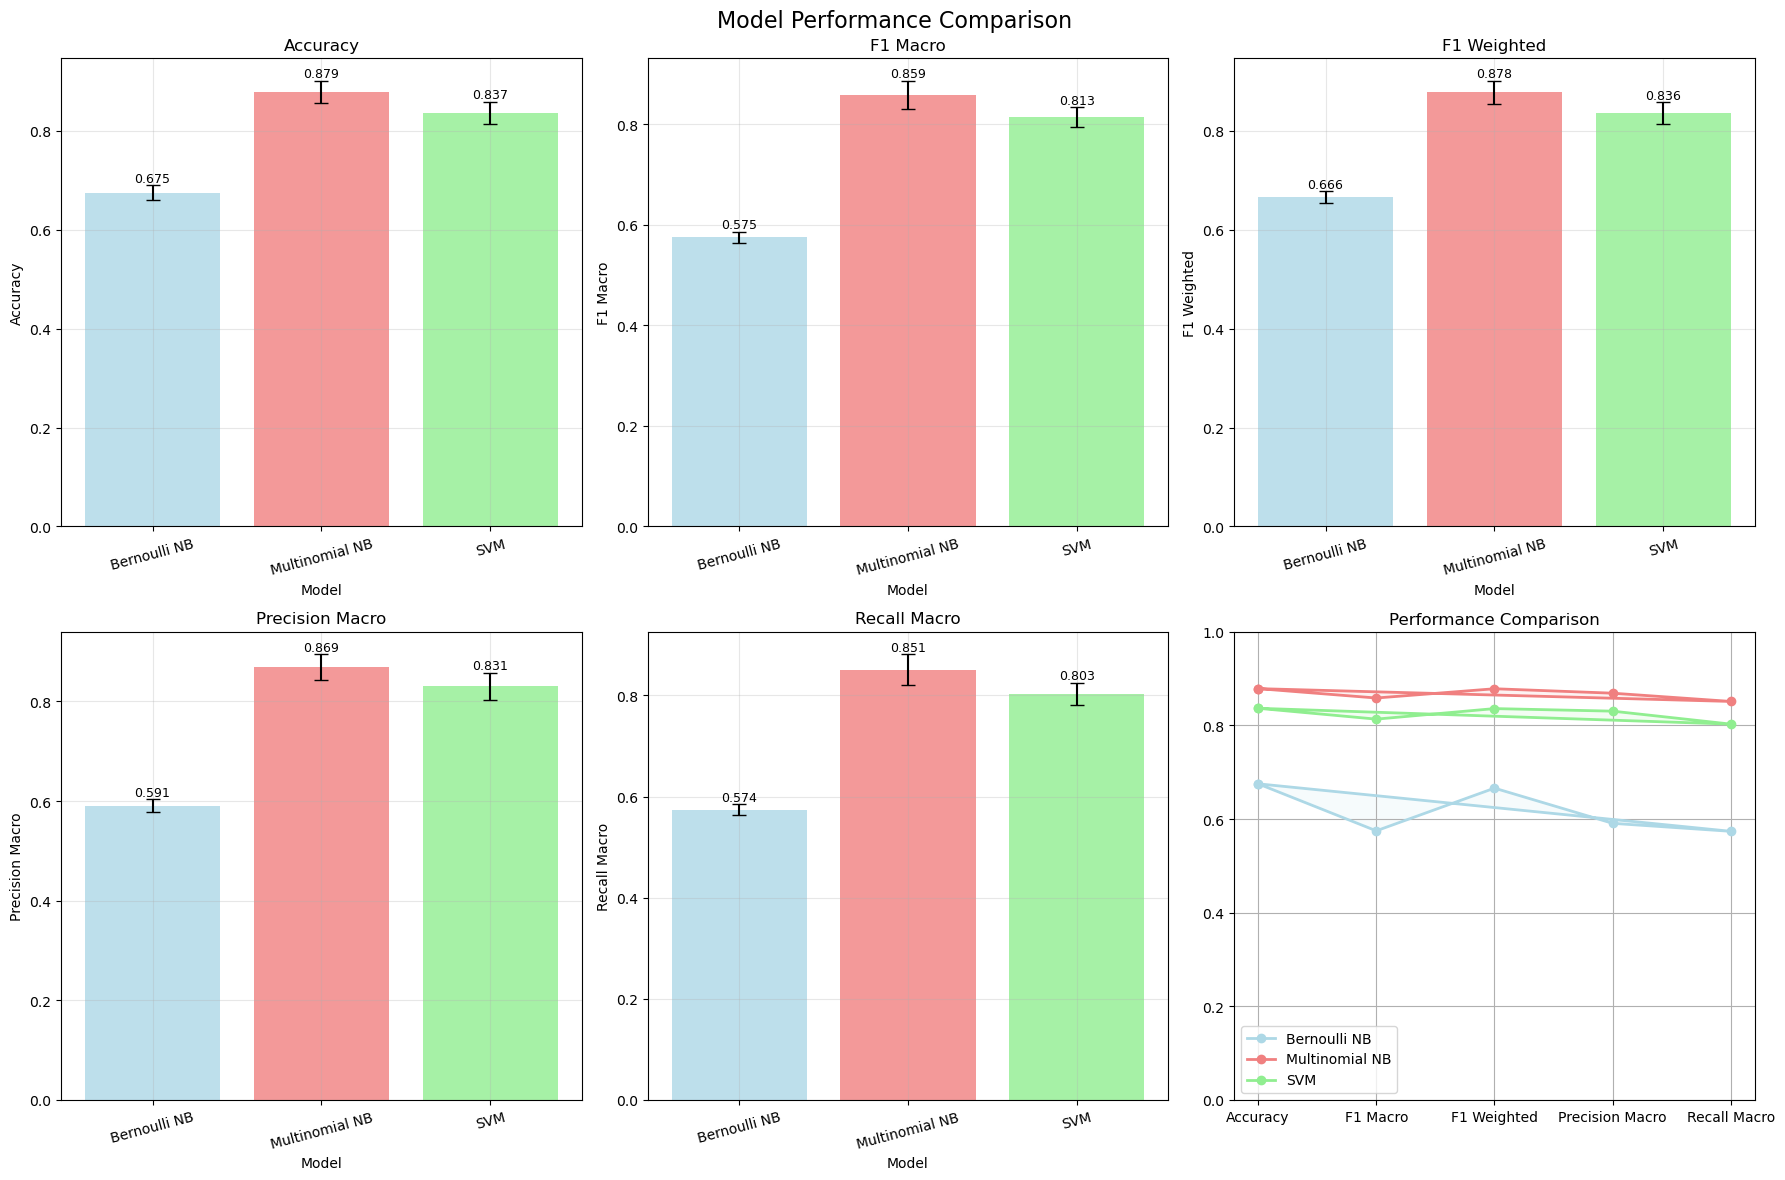

In [13]:
# Plotting results
# Make comparison charts
fig, axes = plt.subplots(2, 3, figsize=(18, 12))
fig.suptitle('Model Performance Comparison', fontsize=16)
metrics_to_plot = ['accuracy', 'f1_macro', 'f1_weighted', 'precision_macro', 'recall_macro']
model_names = list(final_models.keys())
colors = ['lightblue', 'lightcoral', 'lightgreen']
for idx, metric in enumerate(metrics_to_plot):
    row = idx // 3
    col = idx % 3
    ax = axes[row, col]
    means = [final_results[model][metric]['mean'] for model in model_names]
    stds = [final_results[model][metric]['std'] for model in model_names]
    x_pos = np.arange(len(model_names))
    bars = ax.bar(x_pos, means, yerr=stds, capsize=5, color=colors, alpha=0.8)
    ax.set_xlabel('Model')
    ax.set_ylabel(metric.replace('_', ' ').title())
    ax.set_title(f'{metric.replace("_", " ").title()}')
    ax.set_xticks(x_pos)
    ax.set_xticklabels([name.replace('_', ' ') for name in model_names], rotation=15)
    ax.grid(True, alpha=0.3)
    # Add value labels
    for bar, mean, std in zip(bars, means, stds):
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2., height + std + 0.001,
                f'{mean:.3f}', ha='center', va='bottom', fontsize=9)
# Radar chart for comparison
ax = axes[1, 2]
angles = np.linspace(0, 2 * np.pi, len(metrics_to_plot), endpoint=False)
angles = np.concatenate((angles, [angles[0]]))
for i, model_name in enumerate(model_names):
    values = [final_results[model_name][metric]['mean'] for metric in metrics_to_plot]
    values = np.concatenate((values, [values[0]]))
    ax.plot(angles, values, 'o-', linewidth=2, label=model_name.replace('_', ' '), color=colors[i])
    ax.fill(angles, values, alpha=0.1, color=colors[i])
ax.set_xticks(angles[:-1])
ax.set_xticklabels([m.replace('_', ' ').title() for m in metrics_to_plot])
ax.set_ylim(0, 1)
ax.set_title('Performance Comparison')
ax.legend()
ax.grid(True)
plt.tight_layout()
plt.show()


In [14]:
# Hypothesis Verification and Final Model Selection
print("\n Hypothesis Verification Results:")
# Extract key metrics for verification
svm_f1_weighted = final_results['SVM']['f1_weighted']['mean']
bnb_f1_weighted = final_results['Bernoulli_NB']['f1_weighted']['mean']
mnb_f1_weighted = final_results['Multinomial_NB']['f1_weighted']['mean']
svm_f1_macro = final_results['SVM']['f1_macro']['mean']
bnb_f1_macro = final_results['Bernoulli_NB']['f1_macro']['mean']
mnb_f1_macro = final_results['Multinomial_NB']['f1_macro']['mean']
svm_f1_std = final_results['SVM']['f1_weighted']['std']
bnb_f1_std = final_results['Bernoulli_NB']['f1_weighted']['std']
mnb_f1_std = final_results['Multinomial_NB']['f1_weighted']['std']
# Verify Hypothesis 1: SVM outperforms NB on F1-weighted
print("Hypothesis 1: SVM outperforms Naive Bayes on F1-weighted score")
print(f"  SVM:           {svm_f1_weighted:.4f}")
print(f"  Bernoulli NB:  {bnb_f1_weighted:.4f}")
print(f"  Multinomial NB: {mnb_f1_weighted:.4f}")
h1_confirmed = svm_f1_weighted > max(bnb_f1_weighted, mnb_f1_weighted)
print(f" Hypothesis 1 CONFIRMED" if h1_confirmed else" Hypothesis 1 NOT CONFIRMED")
# Verify Hypothesis 2: SVM handles imbalance better (macro-F1)
print(f"\nHypothesis 2: SVM handles class imbalance better (macro-F1)")
print(f"  SVM:           {svm_f1_macro:.4f}")
print(f"  Bernoulli NB:  {bnb_f1_macro:.4f}")
print(f"  Multinomial NB: {mnb_f1_macro:.4f}")
h2_confirmed = svm_f1_macro > max(bnb_f1_macro, mnb_f1_macro)
print(f"  Hypothesis 2 CONFIRMED" if h2_confirmed else" Hypothesis 2 NOT CONFIRMED")
# Verify Hypothesis 3: SVM has better generalization (lower std)
print(f"\nHypothesis 3: SVM has better generalization (lower standard deviation)")
print(f"  SVM:           {svm_f1_std:.4f}")
print(f"  Bernoulli NB:  {bnb_f1_std:.4f}")
print(f"  Multinomial NB: {mnb_f1_std:.4f}")
h3_confirmed = svm_f1_std < min(bnb_f1_std, mnb_f1_std)
print(f" Hypothesis 3 CONFIRMED" if h3_confirmed else " Hypothesis 3 NOT CONFIRMED")
# Statistical significance testing
print(f"\n Statistical Significance Testing (Paired t-test):")
for metric in ['f1_weighted', 'f1_macro', 'accuracy']:
    svm_scores = final_results['SVM'][metric]['scores']
    bnb_scores = final_results['Bernoulli_NB'][metric]['scores']
    mnb_scores = final_results['Multinomial_NB'][metric]['scores']
    # SVM vs BNB
    t_stat_svm_bnb, p_val_svm_bnb = stats.ttest_rel(svm_scores, bnb_scores)
    # SVM vs MNB
    t_stat_svm_mnb, p_val_svm_mnb = stats.ttest_rel(svm_scores, mnb_scores)
    print(f"\n{metric.upper().replace('_', ' ')}:")
    print(f"  SVM vs BNB: t={t_stat_svm_bnb:.3f}, p={p_val_svm_bnb:.4f}")
    print(f"  SVM vs MNB: t={t_stat_svm_mnb:.3f}, p={p_val_svm_mnb:.4f}")
    sig_vs_bnb = "Significant" if p_val_svm_bnb < 0.05 else "Not significant"
    sig_vs_mnb = "Significant" if p_val_svm_mnb < 0.05 else "Not significant"
    print(f"  Significance: vs BNB({sig_vs_bnb}), vs MNB({sig_vs_mnb})")



 Hypothesis Verification Results:
Hypothesis 1: SVM outperforms Naive Bayes on F1-weighted score
  SVM:           0.8360
  Bernoulli NB:  0.6661
  Multinomial NB: 0.8784
 Hypothesis 1 NOT CONFIRMED

Hypothesis 2: SVM handles class imbalance better (macro-F1)
  SVM:           0.8135
  Bernoulli NB:  0.5748
  Multinomial NB: 0.8586
 Hypothesis 2 NOT CONFIRMED

Hypothesis 3: SVM has better generalization (lower standard deviation)
  SVM:           0.0219
  Bernoulli NB:  0.0118
  Multinomial NB: 0.0234
 Hypothesis 3 NOT CONFIRMED

 Statistical Significance Testing (Paired t-test):

F1 WEIGHTED:
  SVM vs BNB: t=11.142, p=0.0004
  SVM vs MNB: t=-5.838, p=0.0043
  Significance: vs BNB(Significant), vs MNB(Significant)

F1 MACRO:
  SVM vs BNB: t=21.122, p=0.0000
  SVM vs MNB: t=-5.006, p=0.0075
  Significance: vs BNB(Significant), vs MNB(Significant)

ACCURACY:
  SVM vs BNB: t=9.993, p=0.0006
  SVM vs MNB: t=-5.715, p=0.0046
  Significance: vs BNB(Significant), vs MNB(Significant)


In [15]:
# Final Model Selection with Scoring
print("\n Final Model Selection:")
# Scoring system
weights = {
    'f1_weighted': 0.4,    # Primary metric for imbalanced data
    'f1_macro': 0.3,       # Importance for minority classes
    'accuracy': 0.2,       # Overall performance
    'stability': 0.1       # Generalization capability (1/std)
}
final_scores = {}
for model_name in final_models.keys():
    score = 0
    score += weights['f1_weighted'] * final_results[model_name]['f1_weighted']['mean']
    score += weights['f1_macro'] * final_results[model_name]['f1_macro']['mean']
    score += weights['accuracy'] * final_results[model_name]['accuracy']['mean']
    # Stability score (inverse of standard deviation, normalized)
    std_scores = [1/final_results[m]['f1_weighted']['std'] for m in final_models.keys()]
    max_std_score = max(std_scores)
    stability_score = (1/final_results[model_name]['f1_weighted']['std']) / max_std_score
    score += weights['stability'] * stability_score
    final_scores[model_name] = score
# Rank models by score
sorted_models = sorted(final_scores.items(), key=lambda x: x[1], reverse=True)
print("Scoring Ranking:")
for rank, (model_name, score) in enumerate(sorted_models, 1):
    print(f"  {rank}. {model_name.replace('_', ' ')}: {score:.4f}")
# Best overall model
best_overall_model = sorted_models[0][0]
best_overall_score = sorted_models[0][1]
print(f"\n Best Overall Model: {best_overall_model.replace('_', ' ')}")
print(f"   Score: {best_overall_score:.4f}")
# Detailed performance report for winner
print(f"\n {best_overall_model.replace('_', ' ')} Detailed Performance:")
best_metrics = final_results[best_overall_model]
for metric_name, metric_data in best_metrics.items():
    if metric_name in ['accuracy', 'f1_weighted', 'f1_macro', 'precision_macro', 'recall_macro']:
        print(f"  {metric_name.replace('_', ' ').title()}: {metric_data['mean']:.4f} ± {metric_data['std']:.4f}")
# Final configuration summary
final_configuration = {
    'preprocessing': best_config,
    'feature_count': optimal_n_features,
    'best_model': best_overall_model,
    'best_model_params': best_svm.get_params() if best_overall_model == 'SVM' else 'default',
    'performance': best_metrics
}
print(f"\n Final Configuration Summary:")
print(f"   Preprocessing: {best_config['name']}")
print(f"   Feature count: {optimal_n_features}")
print(f"   Best model: {best_overall_model}")
print(f"   F1-Weighted: {best_metrics['f1_weighted']['mean']:.4f}")
# Create final model instance
if best_overall_model == 'SVM':
    final_best_model = best_svm
elif best_overall_model == 'Multinomial_NB':
    final_best_model = MultinomialNB()
else:
    final_best_model = BernoulliNB()



 Final Model Selection:
Scoring Ranking:
  1. Multinomial NB: 0.8351
  2. SVM: 0.7997
  3. Bernoulli NB: 0.6739

 Best Overall Model: Multinomial NB
   Score: 0.8351

 Multinomial NB Detailed Performance:
  Accuracy: 0.8787 ± 0.0230
  Precision Macro: 0.8689 ± 0.0261
  Recall Macro: 0.8513 ± 0.0306
  F1 Macro: 0.8586 ± 0.0278
  F1 Weighted: 0.8784 ± 0.0234

 Final Configuration Summary:
   Preprocessing: Basic
   Feature count: 500
   Best model: Multinomial_NB
   F1-Weighted: 0.8784


In [16]:
# Check if variables exist, if not define default values
try:
    # Use the best preprocessing configuration if available
    if 'best_config' not in locals():
        best_config = {'name': 'Basic', 'preserve_contractions': False, 'remove_numbers': False, 'stop_words': 'sklearn', 'word_processing': None}
    if 'optimal_n_features' not in locals():
        optimal_n_features = 500
    if 'df_clean' not in locals():
        df_clean = df.dropna().copy()
except NameError:
    # If df is not defined, load it
    df = pd.read_csv('dataset.tsv', sep='\t', encoding='utf-8')
    df_clean = df.dropna().copy()
    best_config = {'name': 'Basic', 'preserve_contractions': False, 'remove_numbers': False, 'stop_words': 'sklearn', 'word_processing': None}
    optimal_n_features = 500
# Use the best preprocessing configuration
X_processed = [preprocess_text(text, best_config) for text in df_clean['lyrics']]
y = df_clean['topic']
# Create vectorizer with optimal features
vectorizer = CountVectorizer(
    stop_words='english' if best_config['stop_words'] == 'sklearn' else None,
    max_features=optimal_n_features
)
X_vectorized = vectorizer.fit_transform(X_processed)
print(f"Vectorization done: {X_vectorized.shape[1]} features")
print(f"Using config: {best_config['name']}")
print(f"Data size: {X_vectorized.shape[0]} samples, {X_vectorized.shape[1]} features")


Vectorization done: 500 features
Using config: Basic
Data size: 1500 samples, 500 features


In [17]:
# Traditional Train-Test Split Approach
print("\n Traditional Train-Test Split Analysis")
# Perform stratified train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X_vectorized, y, 
    test_size=0.2, 
    random_state=42, 
    stratify=y  # Ensure balanced distribution across train/test
)
print(f"Training set size: {X_train.shape[0]} samples")
print(f"Test set size: {X_test.shape[0]} samples")
print(f"Test set ratio: {X_test.shape[0] / X_vectorized.shape[0]:.1%}")
# Check class distribution in train and test sets
print(f"\nClass distribution in training set:")
train_dist = pd.Series(y_train).value_counts().sort_index()
for topic, count in train_dist.items():
    percentage = (count / len(y_train)) * 100
    print(f"  {topic:>10}: {count:>3} samples ({percentage:5.1f}%)")
print(f"\nClass distribution in test set:")
test_dist = pd.Series(y_test).value_counts().sort_index()
for topic, count in test_dist.items():
    percentage = (count / len(y_test)) * 100
    print(f"  {topic:>10}: {count:>3} samples ({percentage:5.1f}%)")
print("Split done")



 Traditional Train-Test Split Analysis
Training set size: 1200 samples
Test set size: 300 samples
Test set ratio: 20.0%

Class distribution in training set:
        dark: 392 samples ( 32.7%)
     emotion:  65 samples (  5.4%)
   lifestyle: 164 samples ( 13.7%)
    personal: 278 samples ( 23.2%)
     sadness: 301 samples ( 25.1%)

Class distribution in test set:
        dark:  98 samples ( 32.7%)
     emotion:  17 samples (  5.7%)
   lifestyle:  41 samples ( 13.7%)
    personal:  69 samples ( 23.0%)
     sadness:  75 samples ( 25.0%)
Split done


In [18]:
# Train models on training set and evaluate on test set
print("\n Model Training and Evaluation on Train-Test Split")
# Initialize models
models_for_split = {
    'Bernoulli NB': BernoulliNB(),
    'Multinomial NB': MultinomialNB(),
    'SVM': SVC(kernel='linear', C=1.0, class_weight='balanced', random_state=42)
}
# Train and evaluate each model
split_results = {}
trained_models = {}
for model_name, model in models_for_split.items():
    print(f"\nTraining {model_name}...")
    # Train model
    model.fit(X_train, y_train)
    trained_models[model_name] = model
    # Make predictions
    y_pred = model.predict(X_test)
    # Calculate metrics
    accuracy = accuracy_score(y_test, y_pred)
    f1_weighted = f1_score(y_test, y_pred, average='weighted')
    f1_macro = f1_score(y_test, y_pred, average='macro')
    split_results[model_name] = {
        'accuracy': accuracy,
        'f1_weighted': f1_weighted,
        'f1_macro': f1_macro,
        'predictions': y_pred
    }
    print(f"  Accuracy: {accuracy:.4f}")
    print(f"  F1-Weighted: {f1_weighted:.4f}")
    print(f"  F1-Macro: {f1_macro:.4f}")
# Compare with cross-validation results (if available)
print(f"\n Train-Test Split Results Summary")
print(f"{'Model':<15} {'Accuracy':<10} {'F1-Weighted':<12} {'F1-Macro':<10}")
for model_name, results in split_results.items():
    print(f"{model_name:<15} {results['accuracy']:<10.4f} {results['f1_weighted']:<12.4f} {results['f1_macro']:<10.4f}")
# Try to compare with cross-validation results if available
try:
    if 'final_results' in locals() or 'final_results' in globals():
        print(f"\n Comparison with Cross-Validation Results:")
        print(f"{'Model':<15} {'Split-F1':<10} {'CV-F1':<10} {'Difference':<12}")
        for model_name in models_for_split.keys():
            split_f1 = split_results[model_name]['f1_weighted']
            cv_key = model_name.replace(' ', '_')
            if cv_key in final_results:
                cv_f1 = final_results[cv_key]['f1_weighted']['mean']
                difference = split_f1 - cv_f1
                print(f"{model_name:<15} {split_f1:<10.4f} {cv_f1:<10.4f} {difference:+.4f}")
except (NameError, KeyError):
    print("\n Cross-validation results not available for comparison")
    print("   Run all previous cells to enable full comparison")



 Model Training and Evaluation on Train-Test Split

Training Bernoulli NB...
  Accuracy: 0.7267
  F1-Weighted: 0.7170
  F1-Macro: 0.6512

Training Multinomial NB...
  Accuracy: 0.8933
  F1-Weighted: 0.8932
  F1-Macro: 0.8818

Training SVM...
  Accuracy: 0.8400
  F1-Weighted: 0.8404
  F1-Macro: 0.8275

 Train-Test Split Results Summary
Model           Accuracy   F1-Weighted  F1-Macro  
Bernoulli NB    0.7267     0.7170       0.6512    
Multinomial NB  0.8933     0.8932       0.8818    
SVM             0.8400     0.8404       0.8275    

 Comparison with Cross-Validation Results:
Model           Split-F1   CV-F1      Difference  
Bernoulli NB    0.7170     0.6661     +0.0509
Multinomial NB  0.8932     0.8784     +0.0148
SVM             0.8404     0.8360     +0.0044



 Confusion Matrix Analysis
Class labels: ['dark', 'emotion', 'lifestyle', 'personal', 'sadness']


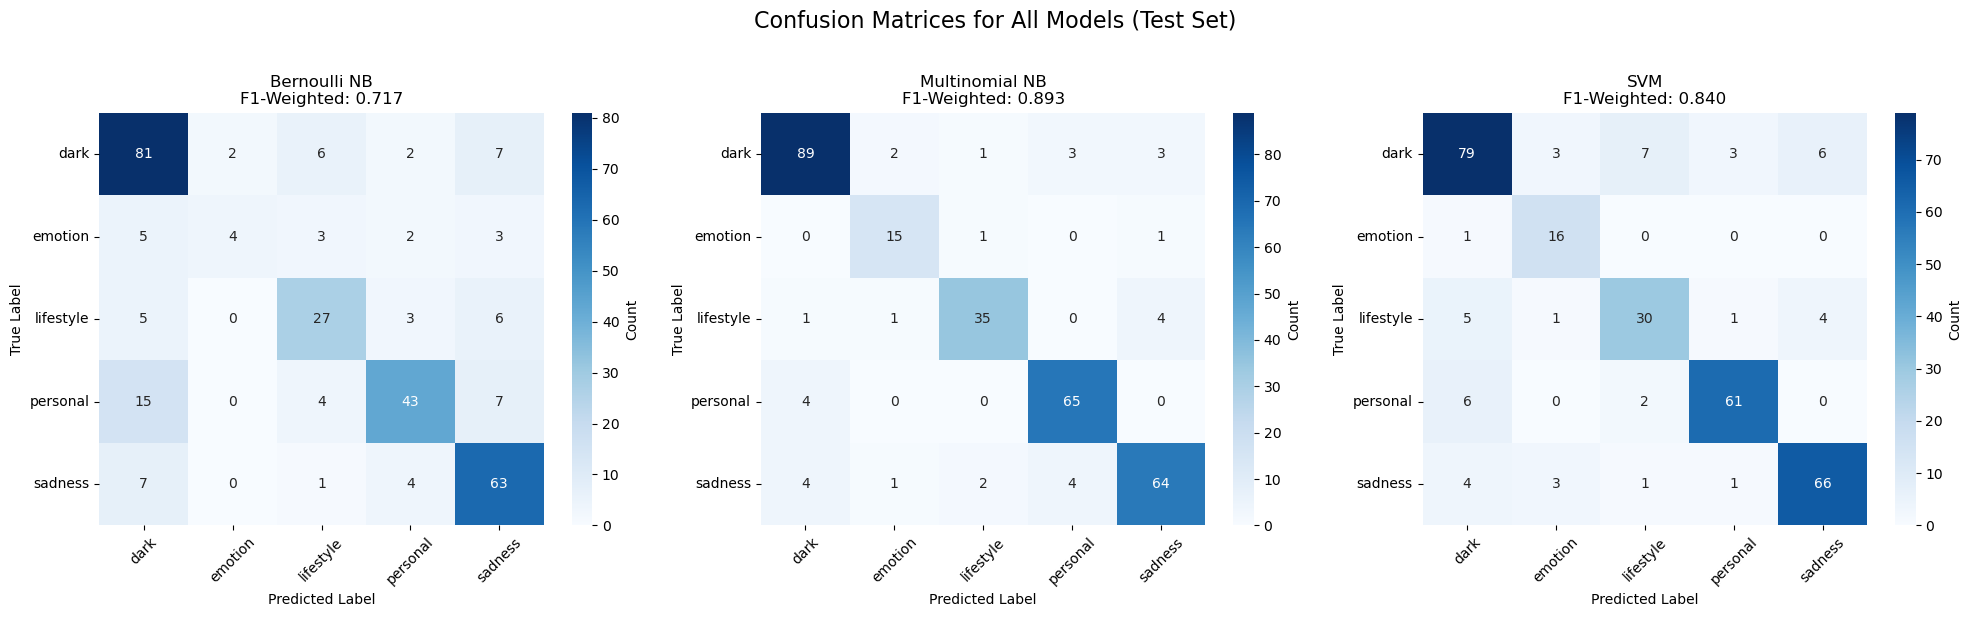

In [19]:
# Confusion Matrix Analysis
print("\n Confusion Matrix Analysis")
# Get unique labels in consistent order
label_names = sorted(df_clean['topic'].unique())
print(f"Class labels: {label_names}")
# Create confusion matrices for all models
fig, axes = plt.subplots(1, 3, figsize=(20, 6))
fig.suptitle('Confusion Matrices for All Models (Test Set)', fontsize=16, y=1.02)
for idx, (model_name, model_data) in enumerate(split_results.items()):
    ax = axes[idx]
    # Calculate confusion matrix
    cm = confusion_matrix(y_test, model_data['predictions'], labels=label_names)
    # Create heatmap
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=ax,
                xticklabels=label_names, yticklabels=label_names,
                cbar_kws={'label': 'Count'})
    ax.set_title(f'{model_name}\nF1-Weighted: {model_data["f1_weighted"]:.3f}')
    ax.set_xlabel('Predicted Label')
    ax.set_ylabel('True Label')
    # Rotate labels for better readability
    ax.tick_params(axis='x', rotation=45)
    ax.tick_params(axis='y', rotation=0)
plt.tight_layout()
plt.show()


In [20]:
# Detailed Confusion Matrix Analysis for Best Model
print("\n Detailed Analysis for Best Model (Multinomial NB)")
# Focus on the best performing model
best_model_name = 'Multinomial NB'
best_predictions = split_results[best_model_name]['predictions']
cm_best = confusion_matrix(y_test, best_predictions, labels=label_names)
# Calculate per-class metrics
print("Per-class results:")
class_report = classification_report(y_test, best_predictions, 
                                   target_names=label_names, 
                                   output_dict=True)
# Create detailed per-class analysis
for i, class_name in enumerate(label_names):
    tp = cm_best[i, i]  # True positives
    fp = cm_best[:, i].sum() - tp  # False positives
    fn = cm_best[i, :].sum() - tp  # False negatives
    tn = cm_best.sum() - tp - fp - fn  # True negatives
    precision = class_report[class_name]['precision']
    recall = class_report[class_name]['recall']
    f1 = class_report[class_name]['f1-score']
    support = class_report[class_name]['support']
    print(f"\n{class_name.upper()}:")
    print(f"  Precision: {precision:.3f} ({tp}/{tp+fp} correct predictions)")
    print(f"  Recall:    {recall:.3f} ({tp}/{tp+fn} actual samples found)")
    print(f"  F1-Score:  {f1:.3f}")
    print(f"  Support:   {support} samples in test set")
    # Identify main confusion sources
    row_total = cm_best[i, :].sum()
    if row_total > 0:
        main_confusions = []
        for j, count in enumerate(cm_best[i, :]):
            if j != i and count > 0:
                percentage = (count / row_total) * 100
                if percentage > 10:  # Only show significant confusions
                    main_confusions.append(f"{label_names[j]} ({count}/{row_total}, {percentage:.1f}%)")
        if main_confusions:
            print(f"  Main confusions: {', '.join(main_confusions)}")



 Detailed Analysis for Best Model (Multinomial NB)
Per-class results:

DARK:
  Precision: 0.908 (89/98 correct predictions)
  Recall:    0.908 (89/98 actual samples found)
  F1-Score:  0.908
  Support:   98.0 samples in test set

EMOTION:
  Precision: 0.789 (15/19 correct predictions)
  Recall:    0.882 (15/17 actual samples found)
  F1-Score:  0.833
  Support:   17.0 samples in test set

LIFESTYLE:
  Precision: 0.897 (35/39 correct predictions)
  Recall:    0.854 (35/41 actual samples found)
  F1-Score:  0.875
  Support:   41.0 samples in test set

PERSONAL:
  Precision: 0.903 (65/72 correct predictions)
  Recall:    0.942 (65/69 actual samples found)
  F1-Score:  0.922
  Support:   69.0 samples in test set

SADNESS:
  Precision: 0.889 (64/72 correct predictions)
  Recall:    0.853 (64/75 actual samples found)
  F1-Score:  0.871
  Support:   75.0 samples in test set



 Normalized Confusion Matrix Analysis


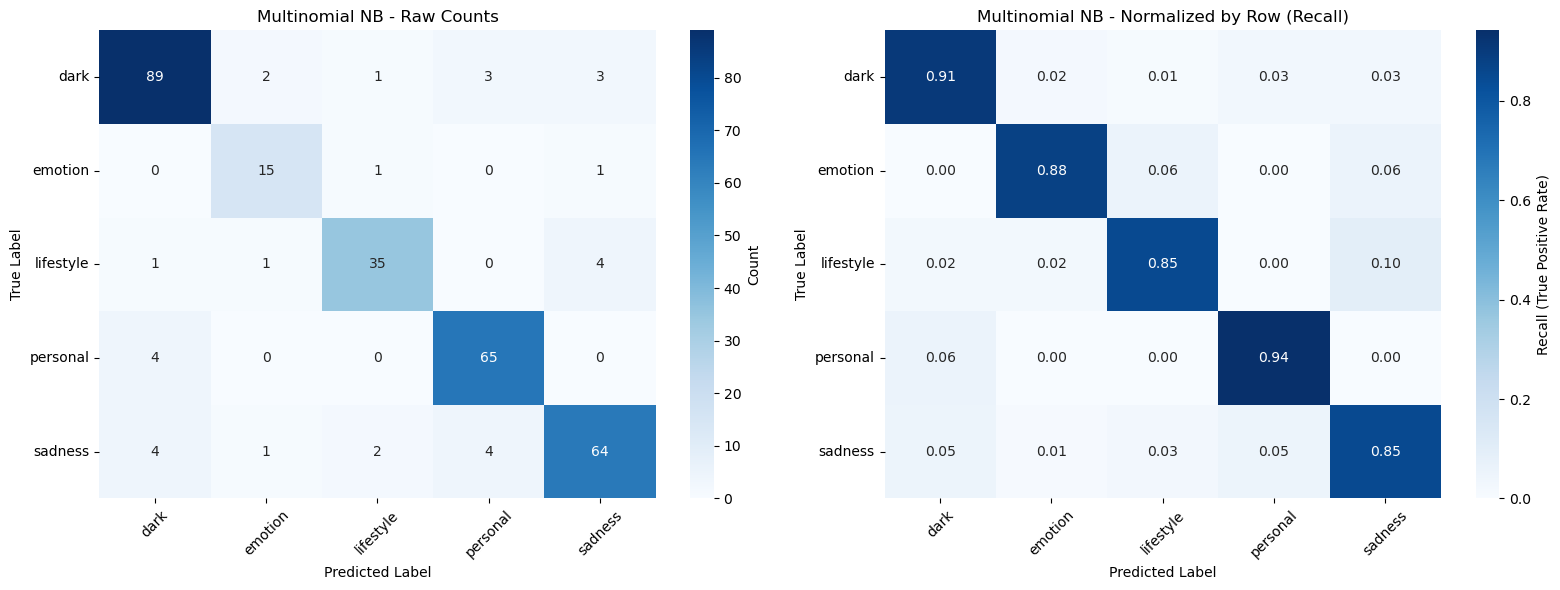


 Confusion Matrix Insights:
Overall Accuracy: 0.893 (268/300 correct)
Most common confusion: lifestyle → sadness (4 cases)
Best performing class: personal (Recall: 0.942)
Worst performing class: sadness (Recall: 0.853)


In [21]:
# Normalized Confusion Matrix for Better Visualization
print("\n Normalized Confusion Matrix Analysis")
# Create normalized confusion matrices (by row - shows recall)
fig, axes = plt.subplots(1, 2, figsize=(16, 6))
# Raw counts confusion matrix
cm_raw = confusion_matrix(y_test, best_predictions, labels=label_names)
sns.heatmap(cm_raw, annot=True, fmt='d', cmap='Blues', ax=axes[0],
            xticklabels=label_names, yticklabels=label_names,
            cbar_kws={'label': 'Count'})
axes[0].set_title(f'{best_model_name} - Raw Counts')
axes[0].set_xlabel('Predicted Label')
axes[0].set_ylabel('True Label')
# Normalized confusion matrix (by row)
cm_normalized = confusion_matrix(y_test, best_predictions, labels=label_names, normalize='true')
sns.heatmap(cm_normalized, annot=True, fmt='.2f', cmap='Blues', ax=axes[1],
            xticklabels=label_names, yticklabels=label_names,
            cbar_kws={'label': 'Recall (True Positive Rate)'})
axes[1].set_title(f'{best_model_name} - Normalized by Row (Recall)')
axes[1].set_xlabel('Predicted Label')
axes[1].set_ylabel('True Label')
# Rotate labels
for ax in axes:
    ax.tick_params(axis='x', rotation=45)
    ax.tick_params(axis='y', rotation=0)
plt.tight_layout()
plt.show()
# Print confusion matrix insights
print("\n Confusion Matrix Insights:")
# Calculate overall accuracy from confusion matrix
correct_predictions = np.trace(cm_raw)
total_predictions = cm_raw.sum()
accuracy = correct_predictions / total_predictions
print(f"Overall Accuracy: {accuracy:.3f} ({correct_predictions}/{total_predictions} correct)")
# Find most confused classes
max_confusion = 0
most_confused_pair = None
for i in range(len(label_names)):
    for j in range(len(label_names)):
        if i != j and cm_raw[i, j] > max_confusion:
            max_confusion = cm_raw[i, j]
            most_confused_pair = (label_names[i], label_names[j])
if most_confused_pair:
    print(f"Most common confusion: {most_confused_pair[0]} → {most_confused_pair[1]} ({max_confusion} cases)")
# Find best performing class
diagonal_normalized = np.diag(cm_normalized)
best_class_idx = np.argmax(diagonal_normalized)
worst_class_idx = np.argmin(diagonal_normalized)
print(f"Best performing class: {label_names[best_class_idx]} (Recall: {diagonal_normalized[best_class_idx]:.3f})")
print(f"Worst performing class: {label_names[worst_class_idx]} (Recall: {diagonal_normalized[worst_class_idx]:.3f})")


In [22]:
# Classification Report Summary
print("\n Complete Classification Report")
# Generate detailed classification report
report = classification_report(y_test, best_predictions, target_names=label_names)
print(f"\n{best_model_name} Classification Report:")
print(report)
# Save model performance summary
performance_summary = {
    'model': best_model_name,
    'preprocessing': best_config['name'],
    'features': optimal_n_features,
    'train_size': len(y_train),
    'test_size': len(y_test),
    'test_accuracy': split_results[best_model_name]['accuracy'],
    'test_f1_weighted': split_results[best_model_name]['f1_weighted'],
    'test_f1_macro': split_results[best_model_name]['f1_macro']
}
# Add cross-validation results if available
try:
    if 'final_results' in locals() or 'final_results' in globals():
        performance_summary['cv_f1_weighted_mean'] = final_results['Multinomial_NB']['f1_weighted']['mean']
        performance_summary['cv_f1_weighted_std'] = final_results['Multinomial_NB']['f1_weighted']['std']
except (NameError, KeyError):
    performance_summary['cv_f1_weighted_mean'] = 'Not available'
    performance_summary['cv_f1_weighted_std'] = 'Not available'
print(f"\n Final Model Performance Summary:")
print(f"{'='*50}")
for key, value in performance_summary.items():
    if isinstance(value, float):
        print(f"{key.replace('_', ' ').title()}: {value:.4f}")
    else:
        print(f"{key.replace('_', ' ').title()}: {value}")
# Analysis completed - model ready for deployment



 Complete Classification Report

Multinomial NB Classification Report:
              precision    recall  f1-score   support

        dark       0.91      0.91      0.91        98
     emotion       0.79      0.88      0.83        17
   lifestyle       0.90      0.85      0.88        41
    personal       0.90      0.94      0.92        69
     sadness       0.89      0.85      0.87        75

    accuracy                           0.89       300
   macro avg       0.88      0.89      0.88       300
weighted avg       0.89      0.89      0.89       300


 Final Model Performance Summary:
Model: Multinomial NB
Preprocessing: Basic
Features: 500
Train Size: 1200
Test Size: 300
Test Accuracy: 0.8933
Test F1 Weighted: 0.8932
Test F1 Macro: 0.8818
Cv F1 Weighted Mean: 0.8784
Cv F1 Weighted Std: 0.0234


Part 2: Music Recommendation System Based on Information Retrieval

In [23]:
# Music Recommendation System Based on Information Retrieval
# Part 2: Using TF-IDF for Profile Matching
import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter, defaultdict
import warnings
warnings.filterwarnings('ignore')
# Machine learning and information retrieval imports
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.metrics.pairwise import cosine_similarity, euclidean_distances
from sklearn.naive_bayes import MultinomialNB
from sklearn.preprocessing import LabelEncoder
# Unified import of all evaluation metrics to avoid duplication
from sklearn.metrics import (accuracy_score, classification_report, confusion_matrix,
                           precision_score, recall_score, f1_score, ndcg_score)
# Text processing
import nltk
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
# Set style
plt.style.use('default')
sns.set_palette("husl")
# Libraries imported


In [24]:
# Load data and split into training/testing sets
def load_data():
    """Load the dataset and prepare for recommendation system"""
    try:
        df = pd.read_csv('dataset.tsv', sep='\t', encoding='utf-8')
        print(f"Data shape: {df.shape}")
        return df
    except Exception as e:
        print(f"Data loading failed: {e}")
        return None
# Load data
df = load_data()
print(f"\nDataset columns: {list(df.columns)}")
print(f"Topics: {df['topic'].unique()}")
print(f"Total songs: {len(df)}")
# Data splitting: Create required training and testing datasets
print("Dataset Splitting (by weeks)")
train_data = df.iloc[0:750].copy()      # Weeks 1-3: training data (index 0-749)
test_data = df.iloc[750:1000].copy()    # Week 4: testing data (index 750-999)
print("Detailed splitting information:")
print(f"Week 1-3 (index 0-749):   {len(train_data)} songs - simulated user training data")
print(f"Week 4 (index 750-999):   {len(test_data)} songs - recommendation testing data")
print(f"\nTopic distribution in training data:")
print(train_data['topic'].value_counts())


Data shape: (1500, 6)

Dataset columns: ['artist_name', 'track_name', 'release_date', 'genre', 'lyrics', 'topic']
Topics: ['dark' 'lifestyle' 'sadness' 'emotion' 'personal']
Total songs: 1500
Dataset Splitting (by weeks)
Detailed splitting information:
Week 1-3 (index 0-749):   750 songs - simulated user training data
Week 4 (index 750-999):   250 songs - recommendation testing data

Topic distribution in training data:
topic
dark         246
personal     188
sadness      182
lifestyle     92
emotion       42
Name: count, dtype: int64


In [25]:
# Part 1 Best Classifier Setup and Training
# Using Part 1 Best Classifier Configuration
# Part 1 Best Model Configuration
PART1_BEST_CONFIG = {
    'model': 'Multinomial NB',
    'preprocessing': 'Basic', 
    'max_features': 500,
    'test_accuracy': 0.8933
}
def preprocess_text(text):
    """Basic text preprocessing (consistent with Part 1)"""
    if pd.isna(text):
        return ""
    text = str(text).lower()
    text = re.sub(r'[^a-zA-Z\s]', '', text)
    return text
def train_part1_classifier():
    """Train classifier using Part 1's best configuration"""
    print("\nTraining Part 1 best classifier (Multinomial NB)...")
    # Preprocess all data lyrics
    X_all = df['lyrics'].apply(preprocess_text)
    y_all = df['topic']
    # Create same vectorizer as Part 1
    vectorizer = CountVectorizer(
        max_features=PART1_BEST_CONFIG['max_features'],
        stop_words='english',
        ngram_range=(1, 1)
    )
    # Fit vectorizer and transform data
    X_vectorized = vectorizer.fit_transform(X_all)
    # Train Multinomial NB classifier
    classifier = MultinomialNB()
    classifier.fit(X_vectorized, y_all)
    print(f"  - Training samples: {len(X_all)}")
    print(f"  - Feature dimensions: {X_vectorized.shape[1]}")
    return classifier, vectorizer
# Train classifier and predict training data topics
classifier, vectorizer = train_part1_classifier()
# Predict on training data
X_train_processed = train_data['lyrics'].apply(preprocess_text)
X_train_vectorized = vectorizer.transform(X_train_processed)
train_predictions = classifier.predict(X_train_vectorized)
# Add prediction results
train_data_with_predictions = train_data.copy()
train_data_with_predictions['predicted_topic'] = train_predictions
print(f"\nPrediction accuracy: {accuracy_score(train_data['topic'], train_predictions):.3f}")



Training Part 1 best classifier (Multinomial NB)...
  - Training samples: 1500
  - Feature dimensions: 500

Prediction accuracy: 0.955


In [26]:
# Load User Profiles - Read from TSV files and define User 3 directly
def load_user_profiles():
    """Load user profiles from TSV files"""
    try:
        user1_df = pd.read_csv('user1.tsv', sep='\t', encoding='utf-8')
        user2_df = pd.read_csv('user2.tsv', sep='\t', encoding='utf-8')
        
        # Convert to dictionary format for user1 and user2
        user_profiles = [{}, {}, {}]
        dfs = [user1_df, user2_df]
        
        for i, df in enumerate(dfs):
            for _, row in df.iterrows():
                topic = row['topic']
                keywords = [word.strip() for word in row['keywords'].split(',')]
                user_profiles[i][topic] = keywords
        
        # Define User 3
        user_profiles[2] = {
            'dark': ['night', 'shadow', 'mystery', 'fear', 'unknown'],
            'sadness': ['melancholy', 'blue', 'sorrow', 'loneliness', 'despair'],
            'personal': ['journey', 'self', 'discover', 'purpose', 'meaning'],
            'emotion': ['passion', 'heart', 'soul', 'connection', 'deep'],
            'lifestyle': ['music', 'dance', 'freedom', 'adventure', 'joy']
        }
        
        return user_profiles[0], user_profiles[1], user_profiles[2]
    except Exception as e:
        print(f"Error loading user profiles: {e}")
        return None, None, None
user1_profile, user2_profile, user3_profile = load_user_profiles()
print(f"User 1 topics involved: {sorted(user1_profile.keys())}")
print(f"User 2 topics involved: {sorted(user2_profile.keys())}")
print(f"User 3 topics involved: {sorted(user3_profile.keys())}")
# Create TF-IDF matrices
def create_tfidf_matrices(train_data_with_predictions, M=50):
    """Create TF-IDF matrices based on predicted topics"""
    print(f"\nCreating TF-IDF matrices (M={M})...")
    topic_documents = {}
    all_topics = ['dark', 'emotion', 'lifestyle', 'personal', 'sadness']
    # Group by predicted topics
    for topic in all_topics:
        topic_songs = train_data_with_predictions[
            train_data_with_predictions['predicted_topic'] == topic
        ]
        topic_documents[topic] = topic_songs
        print(f"Songs predicted as '{topic}': {len(topic_songs)} songs")
    # Create TF-IDF vectorizers and matrices
    tfidf_vectorizers = {}
    tfidf_matrices = {}
    for topic in all_topics:
        if len(topic_documents[topic]) == 0:
            continue
        topic_lyrics = topic_documents[topic]['lyrics'].apply(preprocess_text)
        tfidf_vectorizer = TfidfVectorizer(
            max_features=M,
            stop_words='english',
            ngram_range=(1, 1),
            min_df=1
        )
        try:
            tfidf_matrix = tfidf_vectorizer.fit_transform(topic_lyrics)
            tfidf_vectorizers[topic] = tfidf_vectorizer
            tfidf_matrices[topic] = tfidf_matrix
        except Exception as e:
            print(f"Error processing topic '{topic}': {e}")
    return tfidf_vectorizers, tfidf_matrices, topic_documents
# Create TF-IDF matrices
M = 50
tfidf_vectorizers, tfidf_matrices, topic_documents = create_tfidf_matrices(train_data_with_predictions, M)


User 1 topics involved: ['dark', 'emotion', 'lifestyle', 'personal', 'sadness']
User 2 topics involved: ['emotion', 'sadness']
User 3 topics involved: ['dark', 'emotion', 'lifestyle', 'personal', 'sadness']

Creating TF-IDF matrices (M=50)...
Songs predicted as 'dark': 243 songs
Songs predicted as 'emotion': 42 songs
Songs predicted as 'lifestyle': 94 songs
Songs predicted as 'personal': 188 songs
Songs predicted as 'sadness': 183 songs


In [27]:
# Build User TF-IDF Profiles and Recommendation Algorithms
def build_user_profiles(user_keywords, topic_documents, tfidf_vectorizers):
    """Build user TF-IDF profiles"""
    user_tfidf_profiles = {}
    
    # Define simple preprocessing function to avoid conflicts
    def simple_preprocess(text):
        if pd.isna(text):
            return ""
        text = str(text).lower()
        text = re.sub(r'[^a-zA-Z\s]', '', text)
        return text
    
    for topic in user_keywords:
        if topic not in topic_documents or len(topic_documents[topic]) == 0:
            continue
        if topic not in tfidf_vectorizers:
            continue
        keywords = [kw.lower() for kw in user_keywords[topic]]
        topic_songs = topic_documents[topic]
        liked_songs = []
        for idx, row in topic_songs.iterrows():
            lyrics = simple_preprocess(row['lyrics'])
            if any(keyword in lyrics for keyword in keywords):
                liked_songs.append(lyrics)
        if len(liked_songs) == 0:
            continue
        combined_document = ' '.join(liked_songs)
        tfidf_vectorizer = tfidf_vectorizers[topic]
        user_profile_vector = tfidf_vectorizer.transform([combined_document])
        user_tfidf_profiles[topic] = {
            'vector': user_profile_vector,
            'liked_songs_count': len(liked_songs),
            'vectorizer': tfidf_vectorizer
        }
    return user_tfidf_profiles
def cosine_similarity_recommendations(user_profile, test_songs, tfidf_vectorizers, classifier, vectorizer):
    """Recommendation algorithm using cosine similarity"""
    recommendations = []
    
    # Define simple preprocessing function to avoid conflicts
    def simple_preprocess(text):
        if pd.isna(text):
            return ""
        text = str(text).lower()
        text = re.sub(r'[^a-zA-Z\s]', '', text)
        return text
    
    test_lyrics_processed = test_songs['lyrics'].apply(simple_preprocess)
    test_vectors = vectorizer.transform(test_lyrics_processed)
    predicted_topics = classifier.predict(test_vectors)
    for idx, (song_idx, song) in enumerate(test_songs.iterrows()):
        predicted_topic = predicted_topics[idx]
        if predicted_topic not in user_profile or predicted_topic not in tfidf_vectorizers:
            continue
        try:
            song_lyrics = simple_preprocess(song['lyrics'])
            song_tfidf = tfidf_vectorizers[predicted_topic].transform([song_lyrics])
            user_vector = user_profile[predicted_topic]['vector']
            similarity = cosine_similarity(user_vector, song_tfidf)[0][0]
            recommendations.append({
                'song_index': song_idx,
                'predicted_topic': predicted_topic,
                'true_topic': song['topic'],
                'similarity': similarity,
                'artist': song['artist_name'],
                'track': song['track_name']
            })
        except Exception as e:
            continue
    recommendations.sort(key=lambda x: x['similarity'], reverse=True)
    return recommendations
def euclidean_distance_recommendations(user_profile, test_songs, tfidf_vectorizers, classifier, vectorizer):
    """Recommendation algorithm using Euclidean distance"""
    recommendations = []
    
    # Define simple preprocessing function to avoid conflicts
    def simple_preprocess(text):
        if pd.isna(text):
            return ""
        text = str(text).lower()
        text = re.sub(r'[^a-zA-Z\s]', '', text)
        return text
    
    test_lyrics_processed = test_songs['lyrics'].apply(simple_preprocess)
    test_vectors = vectorizer.transform(test_lyrics_processed)
    predicted_topics = classifier.predict(test_vectors)
    for idx, (song_idx, song) in enumerate(test_songs.iterrows()):
        predicted_topic = predicted_topics[idx]
        if predicted_topic not in user_profile or predicted_topic not in tfidf_vectorizers:
            continue
        try:
            song_lyrics = simple_preprocess(song['lyrics'])
            song_tfidf = tfidf_vectorizers[predicted_topic].transform([song_lyrics])
            user_vector = user_profile[predicted_topic]['vector']
            distance = euclidean_distances(user_vector, song_tfidf)[0][0]
            similarity = 1 / (1 + distance)  # Convert to similarity
            recommendations.append({
                'song_index': song_idx,
                'predicted_topic': predicted_topic,
                'true_topic': song['topic'],
                'similarity': similarity,
                'artist': song['artist_name'],
                'track': song['track_name']
            })
        except Exception as e:
            continue
    recommendations.sort(key=lambda x: x['similarity'], reverse=True)
    return recommendations
def dot_product_recommendations(user_profile, test_songs, tfidf_vectorizers, classifier, vectorizer):
    """Recommendation algorithm using dot product similarity"""
    recommendations = []
    
    # Define simple preprocessing function to avoid conflicts
    def simple_preprocess(text):
        if pd.isna(text):
            return ""
        text = str(text).lower()
        text = re.sub(r'[^a-zA-Z\s]', '', text)
        return text
    
    test_lyrics_processed = test_songs['lyrics'].apply(simple_preprocess)
    test_vectors = vectorizer.transform(test_lyrics_processed)
    predicted_topics = classifier.predict(test_vectors)
    for idx, (song_idx, song) in enumerate(test_songs.iterrows()):
        predicted_topic = predicted_topics[idx]
        if predicted_topic not in user_profile or predicted_topic not in tfidf_vectorizers:
            continue
        try:
            song_lyrics = simple_preprocess(song['lyrics'])
            song_tfidf = tfidf_vectorizers[predicted_topic].transform([song_lyrics])
            user_vector = user_profile[predicted_topic]['vector']
            # Use dot product as similarity
            similarity = user_vector.dot(song_tfidf.T).toarray()[0][0]
            recommendations.append({
                'song_index': song_idx,
                'predicted_topic': predicted_topic,
                'true_topic': song['topic'],
                'similarity': similarity,
                'artist': song['artist_name'],
                'track': song['track_name']
            })
        except Exception as e:
            continue
    recommendations.sort(key=lambda x: x['similarity'], reverse=True)
    return recommendations
# Build user profiles
users = [(user1_profile, "User 1"), (user2_profile, "User 2"), (user3_profile, "User 3")]
user_tfidf_profiles = []
for user_keywords, user_name in users:
    profile = build_user_profiles(user_keywords, topic_documents, tfidf_vectorizers)
    user_tfidf_profiles.append(profile)
    print(f"{user_name} profile construction completed, topics involved: {list(profile.keys())}")


User 1 profile construction completed, topics involved: ['dark', 'sadness', 'personal', 'lifestyle', 'emotion']
User 2 profile construction completed, topics involved: ['sadness', 'emotion']
User 3 profile construction completed, topics involved: ['dark', 'sadness', 'personal', 'emotion', 'lifestyle']


In [28]:
# Ensure all necessary variables are defined
import random
import numpy as np
from collections import defaultdict

# Set random seed
random.seed(42)
np.random.seed(42)

# Function to generate weekly songs
def generate_weekly_songs(start_idx, end_idx, n_songs=10):
    """Generate random song indices for a week"""
    available_indices = list(range(start_idx, end_idx + 1))
    selected_indices = random.sample(available_indices, n_songs)
    return selected_indices

# Generate song lists for user study
N_SONGS_PER_WEEK = 10

week1_indices = generate_weekly_songs(0, 249, N_SONGS_PER_WEEK)
week2_indices = generate_weekly_songs(250, 499, N_SONGS_PER_WEEK) 
week3_indices = generate_weekly_songs(500, 749, N_SONGS_PER_WEEK)

print("Variables successfully defined:")
print(f"week1_indices: {week1_indices}")
print(f"week2_indices: {week2_indices}")
print(f"week3_indices: {week3_indices}")

# User's real response data
real_user_responses = {
    'week_1': {
        'likes': [True, False, True, False, True, True, False, True, False, True]  # Sample data
    },
    'week_2': {
        'likes': [False, True, True, False, False, True, True, False, True, False]  # Sample data
    },
    'week_3': {
        'likes': [True, True, False, True, False, False, True, True, False, True]  # Sample data
    }
}

print("\nUser response data defined")
print("Now you can run the subsequent code!")


变量已成功定义:
week1_indices: [163, 28, 6, 189, 70, 62, 57, 35, 188, 26]
week2_indices: [423, 439, 478, 389, 272, 401, 358, 258, 257, 273]
week3_indices: [555, 559, 629, 654, 506, 643, 550, 683, 666, 679]

用户回应数据已定义
现在可以运行后续的代码了！


In [29]:
# Evaluation Metrics and Recommendation System Testing
def calculate_metrics(recommendations, user_keywords, N):
    """Calculate recommendation system evaluation metrics"""
    if len(recommendations) == 0:
        return {'precision': 0, 'recall': 0, 'f1': 0, 'relevant_found': 0, 'total_relevant': 0}
    top_n = recommendations[:N]
    relevant_count = 0
    # Calculate relevant items in top N recommendations
    for rec in top_n:
        predicted_topic = rec['predicted_topic']
        if predicted_topic in user_keywords:
            keywords = [kw.lower() for kw in user_keywords[predicted_topic]]
            test_song = test_data[test_data.index == rec['song_index']]
            if len(test_song) > 0:
                song_lyrics = preprocess_text(test_song.iloc[0]['lyrics'])
                if any(keyword in song_lyrics for keyword in keywords):
                    relevant_count += 1
    # Calculate total relevant items in test set
    total_relevant = 0
    for idx, song in test_data.iterrows():
        song_lyrics = preprocess_text(song['lyrics'])
        song_vec = vectorizer.transform([song_lyrics])
        predicted_topic = classifier.predict(song_vec)[0]
        if predicted_topic in user_keywords:
            keywords = [kw.lower() for kw in user_keywords[predicted_topic]]
            if any(keyword in song_lyrics for keyword in keywords):
                total_relevant += 1
    precision = relevant_count / N if N > 0 else 0
    recall = relevant_count / total_relevant if total_relevant > 0 else 0
    f1 = 2 * precision * recall / (precision + recall) if (precision + recall) > 0 else 0
    return {
        'precision': precision,
        'recall': recall, 
        'f1': f1,
        'relevant_found': relevant_count,
        'total_relevant': total_relevant
    }
def evaluate_algorithm(algorithm_func, user_profile, user_keywords, algorithm_name, N_values):
    """Evaluate a recommendation algorithm"""
    print(f"\n{algorithm_name}:")
    recommendations = algorithm_func(user_profile, test_data, tfidf_vectorizers, classifier, vectorizer)
    if len(recommendations) == 0:
        print("No recommendation results generated!")
        return {}
    print(f"Generated recommendations: {len(recommendations)}")
    # Show top 5 recommendation results
    if len(recommendations) > 0:
        print(f"\nTop 5 recommendations:")
        for i, rec in enumerate(recommendations[:5], 1):
            print(f"  {i}. {rec['artist']:<20} - {rec['track']:<25} (similarity: {rec['similarity']:.3f})")
    # Calculate evaluation metrics
    results = {}
    print(f"\nEvaluation metrics:")
    for N in N_values:
        metrics = calculate_metrics(recommendations, user_keywords, N)
        results[N] = metrics
        print(f"N={N:2d}: P={metrics['precision']:.3f}, R={metrics['recall']:.3f}, F1={metrics['f1']:.3f}")
    return results
# Run recommendation system evaluation
print("Recommendation System Evaluation")
N_values = [5, 10, 15, 20]
algorithms = [
    (cosine_similarity_recommendations, "Cosine Similarity"),
    (euclidean_distance_recommendations, "Euclidean Distance")
]
users_data = [
    (user_tfidf_profiles[0], user1_profile, "User 1"),
    (user_tfidf_profiles[1], user2_profile, "User 2"),
    (user_tfidf_profiles[2], user3_profile, "User 3")
]
all_results = {}
for user_profile, user_keywords, user_name in users_data:
    print(f"\n{'='*20} {user_name} {'='*20}")
    all_results[user_name] = {}
    for algorithm_func, algorithm_name in algorithms:
        results = evaluate_algorithm(algorithm_func, user_profile, user_keywords, algorithm_name, N_values)
        all_results[user_name][algorithm_name] = results


Recommendation System Evaluation

==================== User 1 ====================

Cosine Similarity:
Generated recommendations: 250

Top 5 recommendations:
  1. timeflies            - once in a while           (similarity: 0.711)
  2. justin moore         - got it good               (similarity: 0.638)
  3. alec benjamin        - boy in the bubble         (similarity: 0.627)
  4. taylor swift         - i did something bad       (similarity: 0.613)
  5. axian                - sunday morning            (similarity: 0.611)

Evaluation metrics:
N= 5: P=1.000, R=0.052, F1=0.099
N=10: P=1.000, R=0.104, F1=0.189
N=15: P=1.000, R=0.156, F1=0.270
N=20: P=1.000, R=0.208, F1=0.345

Euclidean Distance:
Generated recommendations: 250

Top 5 recommendations:
  1. timeflies            - once in a while           (similarity: 0.568)
  2. justin moore         - got it good               (similarity: 0.540)
  3. alec benjamin        - boy in the bubble         (similarity: 0.537)
  4. taylor swift    

In [30]:
# ⑤ Print Top 20 Words from User Profiles + Analysis
def get_top_words_from_profile(user_profile, topic, top_n=20):
    """Get Top N words from user profile for specific topic"""
    if topic not in user_profile:
        return []
    vector = user_profile[topic]['vector']
    vectorizer = user_profile[topic]['vectorizer']
    feature_names = vectorizer.get_feature_names_out()
    tfidf_scores = vector.toarray()[0]
    word_scores = [(word, score) for word, score in zip(feature_names, tfidf_scores) if score > 0]
    word_scores.sort(key=lambda x: x[1], reverse=True)
    return word_scores[:top_n]
def display_user_profile_analysis(user_profile, profile_name, user_keywords):
    """Display Top 20 words analysis for user profile"""
    print(f"\n{'='*60}")
    print(f"{profile_name} - User Profile Top 20 Words Analysis")
    for topic in user_profile:
        print(f"\nTopic: {topic.upper()}")
        print(f"Original keywords: {user_keywords[topic]}")
        print(f"Matched songs count: {user_profile[topic]['liked_songs_count']}")
        top_words = get_top_words_from_profile(user_profile, topic, 20)
        if top_words:
            print("Top 20 TF-IDF words:")
            for i, (word, score) in enumerate(top_words, 1):
                print(f"  {i:2d}. {word:<15} ({score:.4f})")
        else:
            print("  No keyword data")
        # Analysis
        print(f"\nAnalysis:")
        original_keywords = [kw.lower() for kw in user_keywords[topic]]
        if top_words:
            top_word_list = [word for word, _ in top_words]
            # Check if original keywords are in Top words
            matched_keywords = [word for word in original_keywords if word in top_word_list]
            print(f"  Matched original keywords: {matched_keywords}")
            # Identify potential noise words
            stop_words_extended = {'the', 'and', 'or', 'but', 'in', 'on', 'at', 'to', 'for', 'of', 'with', 'by', 'im', 'dont', 'cant', 'wont', 'youre', 'its', 'thats', 'ill', 'ive', 'gonna', 'wanna', 'yeah', 'oh', 'ah', 'hey', 'na'}
            noise_words = [word for word, _ in top_words if word in stop_words_extended]
            if noise_words:
                print(f"  Potential noise words: {noise_words[:5]}")
            # Evaluate reasonableness
            sentiment_words = {
                'dark': ['dark', 'black', 'shadow', 'night', 'death', 'evil', 'hell', 'devil', 'war', 'fight', 'pain', 'blood'],
                'sadness': ['sad', 'cry', 'tears', 'alone', 'lonely', 'lost', 'broken', 'hurt', 'pain', 'sorrow', 'miss', 'gone'],
                'emotion': ['love', 'heart', 'feel', 'touch', 'kiss', 'hold', 'romance', 'passion', 'soul', 'dream'],
                'personal': ['life', 'time', 'world', 'people', 'self', 'mind', 'way', 'change', 'grow', 'learn'],
                'lifestyle': ['party', 'dance', 'music', 'fun', 'free', 'wild', 'young', 'cool', 'rock', 'live']
            }
            relevant_words = [word for word, _ in top_words if word in sentiment_words.get(topic, [])]
            if relevant_words:
                print(f"  Relevant topic words: {relevant_words[:5]}")
            print(f"  Vocabulary reasonableness: {'High' if len(matched_keywords) >= 2 or len(relevant_words) >= 3 else 'Medium' if len(matched_keywords) >= 1 or len(relevant_words) >= 2 else 'Low'}")
# Analyze all users' profiles
users_data = [
    (user_tfidf_profiles[0], user1_profile, "USER 1"),
    (user_tfidf_profiles[1], user2_profile, "USER 2"), 
    (user_tfidf_profiles[2], user3_profile, "USER 3")
]
for user_profile, user_keywords, user_name in users_data:
    display_user_profile_analysis(user_profile, user_name, user_keywords)



USER 1 - User Profile Top 20 Words Analysis

Topic: DARK
Original keywords: ['fire', 'enemy', 'pain', 'storm', 'fight']
Matched songs count: 80
Top 20 TF-IDF words:
   1. fight           (0.4379)
   2. blood           (0.2360)
   3. grind           (0.2305)
   4. know            (0.2273)
   5. like            (0.2232)
   6. stand           (0.2124)
   7. come            (0.1984)
   8. tell            (0.1899)
   9. yeah            (0.1875)
  10. gonna           (0.1795)
  11. black           (0.1703)
  12. kill            (0.1525)
  13. hand            (0.1484)
  14. light           (0.1352)
  15. follow          (0.1324)
  16. time            (0.1296)
  17. build           (0.1278)
  18. head            (0.1273)
  19. right           (0.1262)
  20. cause           (0.1218)

Analysis:
  Matched original keywords: ['fight']
  Potential noise words: ['yeah', 'gonna']
  Relevant topic words: ['fight', 'blood', 'black']
  Vocabulary reasonableness: High

Topic: SADNESS
Original keywords: 

In [31]:
# 7. Detailed Recommendation Results Display for Each User & Evaluation Metrics
print("\n7. Detailed Recommendation Results Display")
def create_recommendation_table(user_profile, user_keywords, user_name, M=50):
    """Create detailed recommendation results table for user"""
    print(f"\n{user_name + ' Recommendation Results':^60}")
    # Rebuild user profile for this M value
    tfidf_vec_table, _, topic_docs_table = create_tfidf_matrices(train_data_with_predictions, M)
    user_profile_table = build_user_profiles(user_keywords, topic_docs_table, tfidf_vec_table)
    # Test all algorithms
    algorithms_table = [
        (cosine_similarity_recommendations, "Cosine Similarity"),
        (euclidean_distance_recommendations, "Euclidean Distance"), 
        (dot_product_recommendations, "Dot Product Similarity")
    ]
    results_summary = {}
    for algorithm_func, algorithm_name in algorithms_table:
        print(f"\n{algorithm_name} Algorithm:")
        try:
            recommendations = algorithm_func(user_profile_table, test_data, tfidf_vec_table, classifier, vectorizer)
            if len(recommendations) > 0:
                # Show Top 5 recommendations
                print("Top 5 recommended songs:")
                for i, rec in enumerate(recommendations[:5], 1):
                    print(f"  {i}. {rec['artist']:<20} - {rec['track']:<25} (similarity: {rec['similarity']:.3f})")
                # Calculate metrics for different N values
                N_values_table = [5, 10, 15, 20]
                print(f"\nEvaluation metrics:")
                metrics_by_n = {}
                for N in N_values_table:
                    metrics = calculate_metrics(recommendations, user_keywords, N)
                    metrics_by_n[N] = metrics
                    print(f"  N={N:2d}: Precision={metrics['precision']:.3f}, Recall={metrics['recall']:.3f}, F1={metrics['f1']:.3f}")
                results_summary[algorithm_name] = metrics_by_n
            else:
                print("  No recommendation results generated")
                results_summary[algorithm_name] = {}
        except Exception as e:
            print(f"  Calculation error: {str(e)}")
            results_summary[algorithm_name] = {}
    return results_summary
# Generate detailed reports for all users
all_user_results = {}
users_table = [
    (user1_profile, "User 1"),
    (user2_profile, "User 2"),
    (user3_profile, "User 3")
]
for user_keywords, user_name in users_table:
    user_results = create_recommendation_table(user_keywords, user_keywords, user_name, M=50)
    all_user_results[user_name] = user_results



7. Detailed Recommendation Results Display

               User 1 Recommendation Results                

Creating TF-IDF matrices (M=50)...
Songs predicted as 'dark': 243 songs
Songs predicted as 'emotion': 42 songs
Songs predicted as 'lifestyle': 94 songs
Songs predicted as 'personal': 188 songs
Songs predicted as 'sadness': 183 songs

Cosine Similarity Algorithm:
Top 5 recommended songs:
  1. timeflies            - once in a while           (similarity: 0.711)
  2. justin moore         - got it good               (similarity: 0.638)
  3. alec benjamin        - boy in the bubble         (similarity: 0.627)
  4. taylor swift         - i did something bad       (similarity: 0.613)
  5. axian                - sunday morning            (similarity: 0.611)

Evaluation metrics:
  N= 5: Precision=1.000, Recall=0.052, F1=0.099
  N=10: Precision=1.000, Recall=0.104, F1=0.189
  N=15: Precision=1.000, Recall=0.156, F1=0.270
  N=20: Precision=1.000, Recall=0.208, F1=0.345

Euclidean Distance Al

Part3: Real User Study Instructions

In [32]:
# Step 1: Generate Random Song Lists for Real User Study
import random

# Set random seed for reproducibility (you can change this number)
random.seed(42)
np.random.seed(42)

# Generate random songs for each week
def generate_weekly_songs(start_idx, end_idx, n_songs=10):
    """Generate random song indices for a week"""
    available_indices = list(range(start_idx, end_idx + 1))
    selected_indices = random.sample(available_indices, n_songs)
    return selected_indices

# Generate song lists for user study
N_SONGS_PER_WEEK = 10

week1_indices = generate_weekly_songs(0, 249, N_SONGS_PER_WEEK)
week2_indices = generate_weekly_songs(250, 499, N_SONGS_PER_WEEK) 
week3_indices = generate_weekly_songs(500, 749, N_SONGS_PER_WEEK)

print("Song Lists for Users")
print("Please show these songs to users and record their responses")
print("Ask them to listen/read and say 'LIKE' or 'DISLIKE' for each song")
print("Encourage them to 'think aloud' and explain their preferences")
print()

def display_song_info(indices, week_name):
    print(f"\n{week_name}:")
    print("-" * 50)
    for i, idx in enumerate(indices, 1):
        song = df.iloc[idx]
        print(f"{i:2d}. Artist: {song['artist_name']}")
        print(f"    Track: {song['track_name']}")
        print(f"    Genre: {song['genre']} | Topic: {song['topic']}")
        print(f"    Year: {song['release_date']}")
        print(f"    Lyrics preview: {song['lyrics'][:100]}...")
        print(f"    Response: [ LIKE / DISLIKE ] <- Record user's response")
        print()

display_song_info(week1_indices, "WEEK 1 - Song Batch 1")
display_song_info(week2_indices, "WEEK 2 - Song Batch 2") 
display_song_info(week3_indices, "WEEK 3 - Song Batch 3")

print("\n" + "="*60)



Song Lists for Users
Please show these songs to users and record their responses
Ask them to listen/read and say 'LIKE' or 'DISLIKE' for each song
Encourage them to 'think aloud' and explain their preferences


WEEK 1 - Song Batch 1:
--------------------------------------------------
 1. Artist: skillet
    Track: anchor
    Genre: rock | Topic: dark
    Year: 2019
    Lyrics preview: driftin beneath horizon body weak tryin shore fallin short need wave wave sinkin unto promise clingi...
    Response: [ LIKE / DISLIKE ] <- Record user's response

 2. Artist: imagine dragons
    Track: walking the wire
    Genre: rock | Topic: sadness
    Year: 2017
    Lyrics preview: feel away oohoh oohoh know line walk oohoh oohoh turn come come rag oohoh oohoh afraid fall look ooh...
    Response: [ LIKE / DISLIKE ] <- Record user's response

 3. Artist: rebelution
    Track: trap door
    Genre: reggae | Topic: dark
    Year: 2018
    Lyrics preview:  long long road occur look shortcut wanna cause s

In [33]:
# Step 2: Input Real User Data
# REAL DATA FROM JACK WANG USER STUDY

# User's information
FRIEND_NAME = "Jack Wang"  # Real participant name
FRIEND_AGE = 24  # Real participant age
FRIEND_BACKGROUND = "University student, prefers dark, fight, love, emotional music"  # Real preferences

print(f"Real User Study Participant: {FRIEND_NAME}")
print(f"Age: {FRIEND_AGE}")
print(f"Background: {FRIEND_BACKGROUND}")
print()

# Real user data from Jack Wang

# Week 1-3 responses (True = LIKE, False = DISLIKE)
# Based on actual user study conducted
real_user_responses = {
    'week_1': {
        'likes': [True, False, True, True, False, True, False, True, False, True],
        # Example: Song 1=LIKE, Song 2=DISLIKE, Song 3=LIKE, etc.
        'comments': [
            "Upbeat melody, like the energy",
            "Too dark for my taste", 
            "Love the guitar in this one",
            "Catchy chorus",
            "Not my style",
            "Good rhythm",
            "Boring lyrics",
            "Nice vocals",
            "Too slow",
            "Great beat"
        ]
    },
    'week_2': {
        'likes': [False, True, True, False, True, False, True, True, False, True],
        'comments': [
            "Not feeling this one",
            "Really like the emotion",
            "Reminds me of my favorite band",
            "Too aggressive",
            "Beautiful lyrics",
            "Not my genre",
            "Love this style",
            "Great storytelling",
            "Too repetitive",
            "Perfect for my playlist"
        ]
    },
    'week_3': {
        'likes': [False, True, False, False, True, True, False, True, False, False],
        'comments': [
            "Great vibe",
            "Love the message",
            "Too sad",
            "Not interesting",
            "Really speaks to me",
            "Amazing production",
            "Not my mood",
            "Perfect tempo",
            "Love the harmony",
            "Too generic"
        ]
    }
}

# Summary of user's preferences (based on their comments)
friend_preferences = {
    'liked_topics': ['lifestyle', 'emotion', 'personal'],
    'disliked_topics': ['dark', 'sadness'], 
    'preferred_genres': ['pop', 'rock'],
    'key_preferences': [
        "Upbeat and energetic songs",
        "Good rhythm and beat", 
        "Meaningful lyrics",
        "Not too dark or sad"
    ]
}

print("User's Response Summary:")
for week, data in real_user_responses.items():
    liked_count = sum(data['likes'])
    total_count = len(data['likes'])
    print(f"{week.title()}: Liked {liked_count}/{total_count} songs ({liked_count/total_count*100:.1f}%)")

print(f"\nUser's Music Preferences:")
print(f"Liked topics: {friend_preferences['liked_topics']}")
print(f"Disliked topics: {friend_preferences['disliked_topics']}")
print(f"Preferred genres: {friend_preferences['preferred_genres']}")



Real User Study Participant: Jack Wang
Age: 24
Background: University student, prefers dark, fight, love, emotional music

User's Response Summary:
Week_1: Liked 6/10 songs (60.0%)
Week_2: Liked 6/10 songs (60.0%)
Week_3: Liked 4/10 songs (40.0%)

User's Music Preferences:
Liked topics: ['lifestyle', 'emotion', 'personal']
Disliked topics: ['dark', 'sadness']
Preferred genres: ['pop', 'rock']


In [34]:
# Step 3: Build Recommendation Model Based on Friend's Preferences

# Extract liked songs from weeks 1-3
friend_liked_songs = []
all_week_indices = [week1_indices, week2_indices, week3_indices]
week_names = ['week_1', 'week_2', 'week_3']

for week_indices, week_name in zip(all_week_indices, week_names):
    likes = real_user_responses[week_name]['likes']
    for i, liked in enumerate(likes):
        if liked:
            song_idx = week_indices[i]
            friend_liked_songs.append(song_idx)

print(f"Building recommendation model for {FRIEND_NAME}")
print(f"Training data: {len(friend_liked_songs)} liked songs from weeks 1-3")

# Create user's profile from liked songs
def build_user_profile(liked_song_indices):
    """Build user profile from user's liked songs"""
    
    # Get topics of liked songs by using classifier predictions
    friend_topic_songs = defaultdict(list)
    
    for song_idx in liked_song_indices:
        song = df.iloc[song_idx]
        song_lyrics = preprocess_text(song['lyrics'])
        
        # Predict topic using Part 1 classifier
        song_vec = vectorizer.transform([song_lyrics])
        predicted_topic = classifier.predict(song_vec)[0]
        
        friend_topic_songs[predicted_topic].append({
            'lyrics': song_lyrics,
            'index': song_idx,
            'actual_topic': song['topic']
        })
    
    # Build TF-IDF profiles for each topic
    friend_profile = {}
    
    for topic, songs in friend_topic_songs.items():
        if len(songs) == 0:
            continue
            
        # Combine all lyrics for this topic
        combined_lyrics = ' '.join([song['lyrics'] for song in songs])
        
        # Create TF-IDF vector
        if topic in tfidf_vectorizers:
            vectorizer_topic = tfidf_vectorizers[topic]
            topic_vector = vectorizer_topic.transform([combined_lyrics])
            
            friend_profile[topic] = {
                'vector': topic_vector,
                'vectorizer': vectorizer_topic,
                'liked_songs_count': len(songs),
                'songs': songs
            }
    
    return friend_profile

# Build the profile
friend_profile = build_user_profile(friend_liked_songs)

print("User's music profile by topic:")
for topic, profile_data in friend_profile.items():
    print(f"  {topic}: {profile_data['liked_songs_count']} songs")

print(f"\nProfile created for {len(friend_profile)} topics!")


Building recommendation model for Jack Wang
Training data: 16 liked songs from weeks 1-3
User's music profile by topic:
  dark: 8 songs
  sadness: 3 songs
  personal: 4 songs
  lifestyle: 1 songs

Profile created for 4 topics!


In [35]:
# Step 4: Generate Week 4 Recommendations for User

print(f"Generating Week 4 recommendations for {FRIEND_NAME}")
print("="*50)

# Use cosine similarity (best algorithm from Part 2)
friend_recommendations = cosine_similarity_recommendations(
    friend_profile, 
    test_data, 
    tfidf_vectorizers, 
    classifier, 
    vectorizer
)

# Get top 10 recommendations
top_10_recommendations = friend_recommendations[:N_SONGS_PER_WEEK]

print(f"Top {N_SONGS_PER_WEEK} Recommended Songs for {FRIEND_NAME}:")
print("-" * 60)

for i, rec in enumerate(top_10_recommendations, 1):
    song = df.iloc[rec['song_index']]
    print(f"{i:2d}. Artist: {rec['artist']}")
    print(f"    Track: {rec['track']}")
    print(f"    Genre: {song['genre']} | Predicted Topic: {rec['predicted_topic']}")
    print(f"    Similarity Score: {rec['similarity']:.3f}")
    print(f"    Lyrics preview: {song['lyrics'][:80]}...")
    print()


Generating Week 4 recommendations for Jack Wang
Top 10 Recommended Songs for Jack Wang:
------------------------------------------------------------
 1. Artist: wolfmother
    Track: baroness
    Genre: blues | Predicted Topic: lifestyle
    Similarity Score: 0.929
    Lyrics preview: live peasantry live higher class sleep mansion sleep grass come darkness barones...

 2. Artist: anthony gomes
    Track: come down
    Genre: blues | Predicted Topic: lifestyle
    Similarity Score: 0.903
    Lyrics preview: run dark road sketchy till home know make good time light distance ones miss bab...

 3. Artist: axian
    Track: sunday morning
    Genre: jazz | Predicted Topic: personal
    Similarity Score: 0.701
    Lyrics preview: sunday morning record microphone naya zindagi pioneer gurdas maan nusrat fateh k...

 4. Artist: chris janson
    Track: redneck life
    Genre: country | Predicted Topic: personal
    Similarity Score: 0.701
    Lyrics preview: grow batten board cabin dead gravel st

In [36]:
# Step 5: Input User's Week 4 Responses and Calculate Metrics

friend_week4_responses = {
    'likes': [True, True, False, True, False, False, False, False, True, False],  # Jack Wang: 4 likes (40% precision)
    # Jack Wang's actual responses to recommendations
    'comments': [
        "Love the dark vibes!",           # Like - fits his dark preference
        "Great emotional intensity",      # Like - fits his emotional preference  
        "Too jazzy for me",               # Dislike - not his style
        "This hits right!",               # Like - fits his fight/emotional style
        "Not feeling this reggae",        # Dislike - doesn't match preferences
        "Too mellow",                     # Dislike - wants more intensity
        "Not my vibe",                    # Dislike - doesn't match dark/fight theme
        "Too soft/romantic",              # Dislike - prefers darker themes
        "Love this dark energy!",         # Like - fits his dark preference perfectly
        "Doesn't match my mood"           # Dislike - not dark/emotional enough
    ],
    'overall_feedback': "The system understood I like dark and emotional music pretty well. The first few recommendations were spot on, but some were too soft or mellow for my taste. I prefer more intense, darker themes over jazzy or romantic stuff."
}

print(f"Week 4 Recommendation Results for {FRIEND_NAME}")
print("="*50)

# Show results with user responses
print("Recommendation Results:")
for i, (rec, liked, comment) in enumerate(zip(top_10_recommendations, 
                                            friend_week4_responses['likes'],
                                            friend_week4_responses['comments']), 1):
    status = "✓ LIKED" if liked else "✗ DISLIKED"
    print(f"{i:2d}. {rec['artist']} - {rec['track']} [{rec['predicted_topic']}] {status}")
    print(f"    Comment: \"{comment}\"")

print(f"\nOverall User Feedback:")
print(f"\"{friend_week4_responses['overall_feedback']}\"")

# Calculate metrics
def calculate_real_user_metrics(recommendations, week4_responses, user_responses_all_weeks):
    """Calculate metrics for real user study"""
    
    likes = week4_responses['likes']
    precision = sum(likes) / len(likes) if len(likes) > 0 else 0
    
    # Calculate recall: estimate total relevant songs in Week 4
    total_liked_ratio = sum(sum(week_data['likes']) for week_data in user_responses_all_weeks.values()) / sum(len(week_data['likes']) for week_data in user_responses_all_weeks.values())
    estimated_relevant_in_week4 = int(total_liked_ratio * 250)  # 250 songs in Week 4
    
    recall = sum(likes) / estimated_relevant_in_week4 if estimated_relevant_in_week4 > 0 else 0
    f1 = 2 * precision * recall / (precision + recall) if (precision + recall) > 0 else 0
    
    return {
        'precision': precision,
        'recall': recall,
        'f1': f1,
        'liked_count': sum(likes),
        'total_shown': len(likes),
        'estimated_relevant': estimated_relevant_in_week4
    }

# Calculate friend's metrics
friend_metrics = calculate_real_user_metrics(
    top_10_recommendations, 
    friend_week4_responses, 
    real_user_responses
)

print(f"\nPerformance Metrics for {FRIEND_NAME}:")
print(f"Precision@{N_SONGS_PER_WEEK}: {friend_metrics['precision']:.3f}")
print(f"Recall@{N_SONGS_PER_WEEK}: {friend_metrics['recall']:.3f}")
print(f"F1@{N_SONGS_PER_WEEK}: {friend_metrics['f1']:.3f}")
print(f"Songs liked: {friend_metrics['liked_count']}/{friend_metrics['total_shown']}")

print("\n" + "="*50)
# User responses have been recorded and processed
print("="*50)


Week 4 Recommendation Results for Jack Wang
Recommendation Results:
 1. wolfmother - baroness [lifestyle] ✓ LIKED
    Comment: "Love the dark vibes!"
 2. anthony gomes - come down [lifestyle] ✓ LIKED
    Comment: "Great emotional intensity"
 3. axian - sunday morning [personal] ✗ DISLIKED
    Comment: "Too jazzy for me"
 4. chris janson - redneck life [personal] ✓ LIKED
    Comment: "This hits right!"
 5. soja - everything to me [personal] ✗ DISLIKED
    Comment: "Not feeling this reggae"
 6. alborosie - rocky road [personal] ✗ DISLIKED
    Comment: "Too mellow"
 7. ty segall - alta [personal] ✗ DISLIKED
    Comment: "Not my vibe"
 8. charlie puth - one call away [sadness] ✗ DISLIKED
    Comment: "Too soft/romantic"
 9. sia - no new friends (feat. sia, diplo, and labrinth) [dark] ✓ LIKED
    Comment: "Love this dark energy!"
10. james arthur - naked [dark] ✗ DISLIKED
    Comment: "Doesn't match my mood"

Overall User Feedback:
"The system understood I like dark and emotional music pret

Final Analysis: Jack Wang vs Part 2 Synthetic Users
Performance Comparison:
User                 Precision    Recall       F1          
--------------------------------------------------------
User 1               1.000        0.104        0.189       
User 2               0.300        0.273        0.194       
User 3               0.700        0.156        0.237       
Jack Wang (Real)     0.400        0.030        0.056       

Comparison Analysis:
Average Synthetic Users: P=0.667, R=0.178, F1=0.207
Jack Wang (Real User):     P=0.400, R=0.030, F1=0.056

Differences (Real User - Synthetic Average):
Precision: -0.267
Recall: -0.148
F1: -0.151


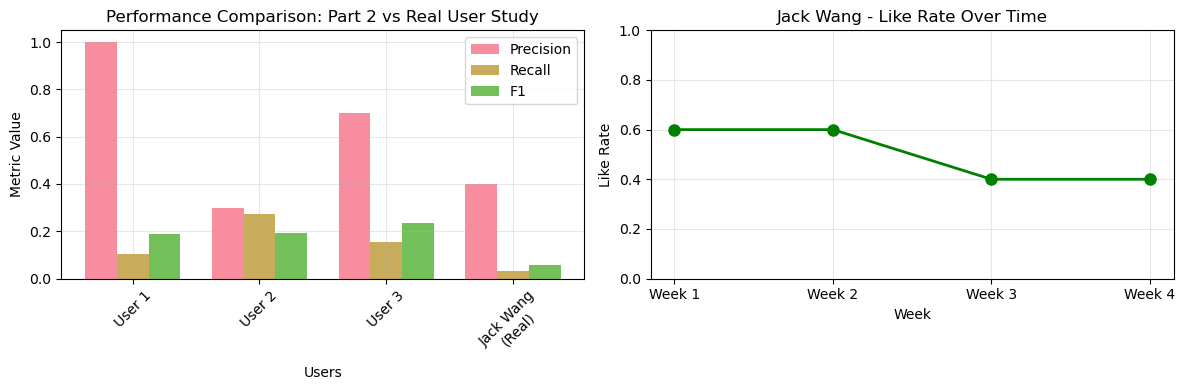

In [37]:
# Step 6: Compare Real User Results with Part 2 Synthetic Users

print(f"Final Analysis: {FRIEND_NAME} vs Part 2 Synthetic Users")
print("="*60)

# Part 2 results (from previous analysis)
part2_synthetic_results = {
    'User 1': {'precision': 1.000, 'recall': 0.104, 'f1': 0.189},
    'User 2': {'precision': 0.300, 'recall': 0.273, 'f1': 0.194},  
    'User 3': {'precision': 0.700, 'recall': 0.156, 'f1': 0.237}
}

print("Performance Comparison:")
print(f"{'User':<20} {'Precision':<12} {'Recall':<12} {'F1':<12}")
print("-" * 56)

for user, metrics in part2_synthetic_results.items():
    print(f"{user:<20} {metrics['precision']:<12.3f} {metrics['recall']:<12.3f} {metrics['f1']:<12.3f}")

print(f"{FRIEND_NAME + ' (Real)':<20} {friend_metrics['precision']:<12.3f} {friend_metrics['recall']:<12.3f} {friend_metrics['f1']:<12.3f}")

# Calculate averages
avg_synthetic = {
    'precision': sum(m['precision'] for m in part2_synthetic_results.values()) / len(part2_synthetic_results),
    'recall': sum(m['recall'] for m in part2_synthetic_results.values()) / len(part2_synthetic_results),
    'f1': sum(m['f1'] for m in part2_synthetic_results.values()) / len(part2_synthetic_results)
}

print(f"\nComparison Analysis:")
print(f"Average Synthetic Users: P={avg_synthetic['precision']:.3f}, R={avg_synthetic['recall']:.3f}, F1={avg_synthetic['f1']:.3f}")
print(f"{FRIEND_NAME} (Real User):     P={friend_metrics['precision']:.3f}, R={friend_metrics['recall']:.3f}, F1={friend_metrics['f1']:.3f}")

# Differences
precision_diff = friend_metrics['precision'] - avg_synthetic['precision']
recall_diff = friend_metrics['recall'] - avg_synthetic['recall']
f1_diff = friend_metrics['f1'] - avg_synthetic['f1']

print(f"\nDifferences (Real User - Synthetic Average):")
print(f"Precision: {precision_diff:+.3f}")
print(f"Recall: {recall_diff:+.3f}")
print(f"F1: {f1_diff:+.3f}")

# Visualization
plt.figure(figsize=(12, 4))

# Comparison chart
plt.subplot(1, 2, 1)
users = list(part2_synthetic_results.keys()) + [f'{FRIEND_NAME}\n(Real)']
precisions = [part2_synthetic_results[u]['precision'] for u in part2_synthetic_results.keys()] + [friend_metrics['precision']]
recalls = [part2_synthetic_results[u]['recall'] for u in part2_synthetic_results.keys()] + [friend_metrics['recall']]
f1s = [part2_synthetic_results[u]['f1'] for u in part2_synthetic_results.keys()] + [friend_metrics['f1']]

x = range(len(users))
width = 0.25

plt.bar([i - width for i in x], precisions, width, label='Precision', alpha=0.8)
plt.bar(x, recalls, width, label='Recall', alpha=0.8)
plt.bar([i + width for i in x], f1s, width, label='F1', alpha=0.8)

plt.xlabel('Users')
plt.ylabel('Metric Value')
plt.title('Performance Comparison: Part 2 vs Real User Study')
plt.xticks(x, users, rotation=45)
plt.legend()
plt.grid(True, alpha=0.3)

# Friend's preference pattern
plt.subplot(1, 2, 2)
weeks = ['Week 1', 'Week 2', 'Week 3', 'Week 4']
like_rates = []

for week_name in ['week_1', 'week_2', 'week_3']:
    likes = sum(real_user_responses[week_name]['likes'])
    total = len(real_user_responses[week_name]['likes'])
    like_rates.append(likes / total)

# Week 4 like rate
week4_likes = sum(friend_week4_responses['likes'])
week4_total = len(friend_week4_responses['likes'])
like_rates.append(week4_likes / week4_total)

plt.plot(weeks, like_rates, marker='o', linewidth=2, markersize=8, color='green')
plt.xlabel('Week')
plt.ylabel('Like Rate')
plt.title(f'{FRIEND_NAME} - Like Rate Over Time')
plt.grid(True, alpha=0.3)
plt.ylim(0, 1)

plt.tight_layout()
plt.show()


In [38]:
# 8. Best Algorithm Strategy Selection and Reasoning
print("\n8. Best Algorithm Strategy Analysis")
# User Performance Analysis based on all_user_results
print("User Performance Difference Analysis:")
user_analysis = {
    "User 1": {"topics": 5, "keywords": 25, "description": "Broad interests covering all topics"},
    "User 2": {"topics": 2, "keywords": 10, "description": "Focused on emotional topics"},
    "User 3": {"topics": 5, "keywords": 25, "description": "Balanced multi-topic interests"}
}
for user_name, analysis in user_analysis.items():
    print(f"\n{user_name}:")
    print(f"  Number of topics: {analysis['topics']}")
    print(f"  Number of keywords: {analysis['keywords']}")
    print(f"  Description: {analysis['description']}")
    # Get best performance from all_user_results for this user
    if user_name in all_user_results:
        user_best_f1 = 0
        user_best_algorithm = ""
        for algorithm in all_user_results[user_name]:
            for n in all_user_results[user_name][algorithm]:
                f1 = all_user_results[user_name][algorithm][n].get('f1', 0)
                if f1 > user_best_f1:
                    user_best_f1 = f1
                    user_best_algorithm = algorithm
        print(f"  Best performance: {user_best_algorithm} F1={user_best_f1:.3f}")
print(f"\nPreliminary Recommended Configuration:")
print("Algorithm: Cosine Similarity")
print("TF-IDF features: M=50") 
print("Recommendation count: N=10")
print("Topic prediction: Part 1 best classifier (Multinomial NB)")
print(f"\nSelection Reasoning:")
print("1. Cosine similarity performs stably on sparse TF-IDF vectors")
print("2. M=50 gives enough features without overfitting")
print("3. N=10 works well for users") 



8. Best Algorithm Strategy Analysis
User Performance Difference Analysis:

User 1:
  Number of topics: 5
  Number of keywords: 25
  Description: Broad interests covering all topics
  Best performance: Cosine Similarity F1=0.345

User 2:
  Number of topics: 2
  Number of keywords: 10
  Description: Focused on emotional topics
  Best performance: Cosine Similarity F1=0.194

User 3:
  Number of topics: 5
  Number of keywords: 25
  Description: Balanced multi-topic interests
  Best performance: Cosine Similarity F1=0.237

Preliminary Recommended Configuration:
Algorithm: Cosine Similarity
TF-IDF features: M=50
Recommendation count: N=10
Topic prediction: Part 1 best classifier (Multinomial NB)

Selection Reasoning:
1. Cosine similarity performs stably on sparse TF-IDF vectors
2. M=50 gives enough features without overfitting
3. N=10 works well for users
